# Raw data analisys 

As part of the preprocessing, a quick check of the raw data downloaded from ChEMBL is going to be carried out. 

In this section we will analize the difference between the molecules label as actives or inactive in the column "Comment". 

In [1]:
import pandas as pd
pd.options.display.max_columns = None

## Data downloaded from ChEMBL 

As the data presented in the contest did not have all columns. Direct download from ChEMBL was carried out searching for "Beta-lactamase AmpC" as the target. The downloaded file was saved as *molecule_activity* 

In [2]:
df = pd.read_csv('./molecule_activity.csv',sep=';')
df.columns[0:20]

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI'],
      dtype='object')

As we can see, there is a columns called "Comment" which is describes as:

*"Activity comments may provide the overall activity conclusions from the data depositor (e.g. toxic, non-toxic, active, inactive) after taking into account other factors such as counter screens. This can explain cases where compounds with apparently potent activities are flagged as inactive/inconclusive."*

From: https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions

## My interpretation
This tell us that this comments are good source to distinguish between actives and inactives with more presicion.

## Split of the data set into 3 categories: 

The main idea is to subtract from the undefined set, the molecules that are active or inactive not using an arbitrary pChEMBL value cutoff. As I found in some ChEMBL preprocessing pipelines, the column *Comment* is used as a first criteria to split the data, so in this case the comments used were: 

* Actives
* Inactives
* Inconclusive

Papers using this aproach:
<div class="csl-entry">Mayr, A., Klambauer, G., Unterthiner, T., Steijaert, M., Wegner, J. K., Ceulemans, H., Clevert, D. A., &#38; Hochreiter, S. (2018). Large-scale comparison of machine learning methods for drug target prediction on ChEMBL. <i>Chemical Science</i>, <i>9</i>(24), 5441–5451. https://doi.org/10.1039/C8SC00148K</div>

In [this paper](https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31) the autors did not use the ambiguos results of the HTS study.

https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31


In [3]:
df.Comment.value_counts().head(10)

Inconclusive               52677
Not Active                  8951
Active                       165
Not Determined                 7
Not applicable                 4
Hydrolysis not detected        2
324165                         1
324147                         1
324209                         1
324191                         1
Name: Comment, dtype: int64

As we can see, the most repeated values are Inconclusive, Not active, and Active ones. The rest of the values are going to be deleted from the data set since they are ambiguous. 
First, we are going to analysis the values of the actives and inactive in the same data frame. 

In [4]:
df_inconclusive = df[(df.Comment == 'Inconclusive')]
df_act_inac = df[(df.Comment == 'Active') | (df.Comment == 'Not Active')]

## pChEMBL value in the active and inactive sets
As the value of the pChEMBL was proposed as the main distintion for active molecules and inactives, it would be pertinet to actually check if it is a good idea.

In [6]:
# By counts
df_count = df_act_inac.groupby(['Standard Type', 'Comment']).count()[['pChEMBL Value', 'Standard Value']]
# By mean
df_mean = df_act_inac.groupby(['Standard Type', 'Comment']).mean()[['pChEMBL Value', 'Standard Value']]
# By std
df_std = df_act_inac.groupby(['Standard Type', 'Comment']).std()[['pChEMBL Value', 'Standard Value']]

### Count grouping by 'Standard Type' and 'Comment'

In [7]:
df_count

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active              0               0
Inhibition    Not Active              0               0
Ki            Active                  8               8
No change     Not Active              0               0
Potency       Active                157             157
              Not Active           8886            8886

Active/Inactive molecules are only present in the Potency Standard value, which is a general representation of the activity. It would be desirable build a dataset based only in one ST but only potency is available. There are also active molecules for the Ki ST but are only 8. Those will be considered in the dataset. 

### Mean grouping by 'Standard Type' and 'Comment'

In [13]:
df_mean

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           4.895000    13500.000000
No change     Not Active            NaN             NaN
Potency       Active           4.601975    37869.515924
              Not Active       4.978202    37462.626052

This part goes interesting, since the mean value in both datasets have very similar pChEMBL values for the active and inactive molecules, but what is weird is that the mean of inactive molecules is higher than the mean of active ones. That means that pChEMBL value is not that reliable to distinguish between actives and inactives. To make this more visual, there will be presented the histogram for the pChEMBL value for each dataset. 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df_act = df_act_inac[df_act_inac['Comment'] == 'Active']
df_inact = df_act_inac[df_act_inac['Comment'] == 'Not Active']

df_act_counts = df_act.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_inact_counts = df_inact.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_act_counts.columns = ['pChEMBL Value', 'Relative Count']
df_inact_counts.columns = ['pChEMBL Value', 'Relative Count']

# Standarizing
df_act_counts['Relative Count'] = (df_act_counts['Relative Count'] / df_act_counts['Relative Count'].sum()) * 100
df_inact_counts['Relative Count'] = (df_inact_counts['Relative Count'] / df_inact_counts['Relative Count'].sum()) * 100

#### Actives

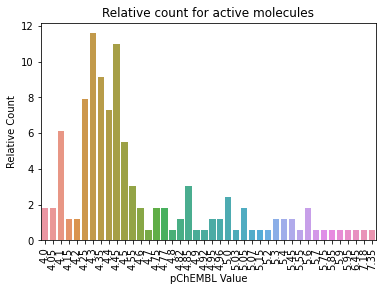

In [9]:
sns.barplot(x = df_act_counts['pChEMBL Value'], y = df_act_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for active molecules')
plt.show()

Text(0.5, 1.0, 'Counts for active molecules')

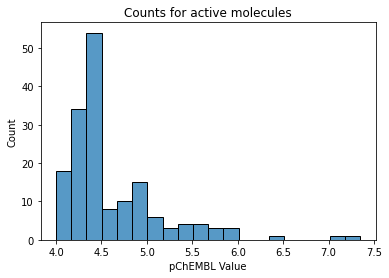

In [10]:
sns.histplot(df_act['pChEMBL Value'], bins=20)
plt.title('Counts for active molecules')

Its important to note that a big quantity of the pChEMBL values for active molecules are low, being almost half of the records between 4.25 and 5.0.

#### Inactives

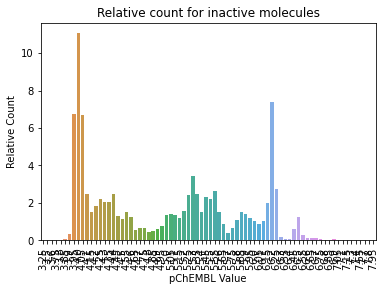

In [11]:
sns.barplot(x = df_inact_counts['pChEMBL Value'], y = df_inact_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for inactive molecules')
plt.show()

Text(0.5, 1.0, 'Counts for inactive molecules')

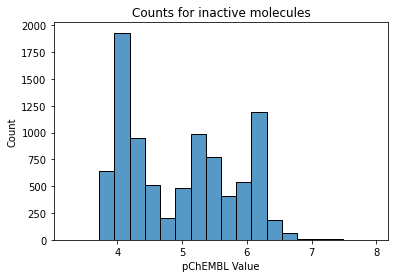

In [12]:
sns.histplot(df_inact['pChEMBL Value'], bins=20)
plt.title('Counts for inactive molecules')


Also the inactives molecules have many molecules with high pChEMBL value.

#### Inconclusive

Text(0.5, 1.0, 'Counts for inconclusive molecules')

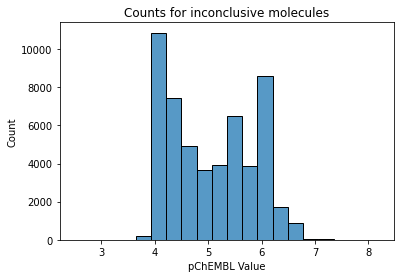

In [13]:
sns.histplot(df_inconclusive['pChEMBL Value'], bins=20)
plt.title('Counts for inconclusive molecules')

In the inconclusive values, there is not clear bias in the pChEMBL value, that is ok, since it represents a pool of possible active/inactive values. 
As a conclusion, there is not clear difference in pChEMBL value between active and inactive molecules since all distributions looks centered. 

### Std grouping by 'Standard Type' and 'Comment'

In [14]:
df_std

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           0.178646     4140.393356
No change     Not Active            NaN             NaN
Potency       Active           0.550129    23917.411609
              Not Active       0.849518    42650.491602

## Saving the dataframes in different csv files

First, we are going to select the columns that are going to be usefull in the future

In [26]:
columns = ['Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'BAO Label', 'Target Name']
columns_desired_name = ['Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value', 'Standard_Units', 'pChEMBL_Value', 'BAO_Label', 'Target_Name']

df_act = df_act[columns]
df_inact = df_inact[columns]
df_inconclusive = df_inconclusive[columns]

df_act.columns = columns_desired_name
df_inact.columns = columns_desired_name
df_inconclusive.columns = columns_desired_name

Now we save the dataframes in diferent files

In [17]:
df_act.to_csv('./actives.csv', index=False)
df_inact.to_csv('./inactives.csv', index=False)
df_inconclusive.to_csv('./inconclusive.csv', index=False)

## Analyzing some molecule properties between molecules datasets

Part of the code was taken from the book: 
* Bharath Ramsundar, Peter Eastman, Patrick Walters, Vijay Pande - Deep Learning for the Life Sciences_ Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More-O’Reilly Media (2019)

In [29]:
from rdkit import Chem # RDKit libraries for chemistry functions
from rdkit.Chem import Draw # Drawing chemical structures
import pandas as pd # Dealing with data in tables
from rdkit.Chem import PandasTools # Manipulating chemical data
from rdkit.Chem import Descriptors # Calculating molecular descriptors
from rdkit.Chem import rdmolops # Additional molecular properties
import seaborn as sns # Making graphs 
import numpy as np

%matplotlib inline

In [27]:
df_act = df_act[['Smiles', 'pChEMBL_Value']]
df_inact = df_inact[['Smiles', 'pChEMBL_Value']]
df_inconclusive = df_inconclusive[['Smiles', 'pChEMBL_Value']]

In [32]:
def molFromSmiles(smiles):
    if isinstance(smiles, str):
        return Chem.MolFromSmiles(smiles)
    else:
        return False
    
def wtFromMol(mol):
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return 0
    
def MolLogP(mol):
    if mol:
        return Descriptors.MolLogP(mol)
    else:
        return 0
    
def GetFormalCharge(mol):
    if mol:
        return rdmolops.GetFormalCharge(mol)
    else:
        return 0

def add_property_columns_to_df(df_in):
    df_in['MW'] = [wtFromMol(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["logP"] = [MolLogP(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["charge"] = [GetFormalCharge(molFromSmiles(smiles)) for smiles in df_in.Smiles]


In [33]:
add_property_columns_to_df(df_act)
add_property_columns_to_df(df_inact)
add_property_columns_to_df(df_inconclusive)

In [36]:
df_act = df_act.assign(status='Active')
df_inact = df_inact.assign(status='Inactive')

df_act_inac = pd.concat([df_act, df_inact]).sample(frac=1).sample(frac=1).sample(frac=1)

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='MW'>

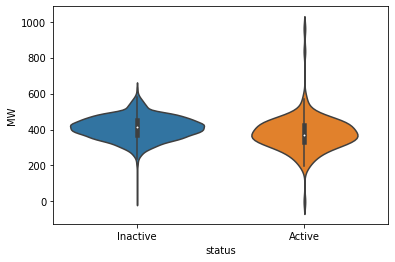

In [37]:
sns.violinplot(df_act_inac["status"],df_act_inac["MW"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='logP'>

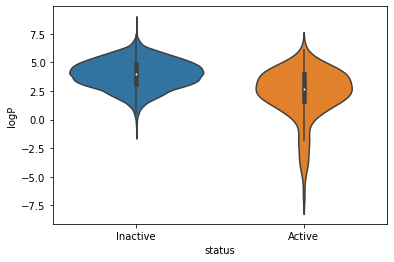

In [38]:
sns.violinplot(df_act_inac["status"],df_act_inac["logP"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='charge'>

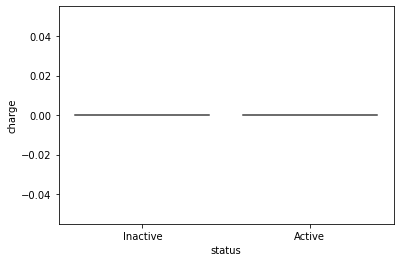

In [39]:
sns.violinplot(df_act_inac["status"],df_act_inac["charge"])

Molecule properties will be revised again at the end of the preprocess

# Basic filtering
In this section, a basic filtering, standardization, and aggregation of duplicates by dataset is going to be carried out. After that, a rd_filter is going to be applied. 

In [4]:
import pandas as pd
import numpy as np

## Reading of files in different dataframes

In [6]:
df_act = pd.read_csv('./raw_data/actives.csv')
df_inact = pd.read_csv('./raw_data/inactives.csv')
df_inc = pd.read_csv('./raw_data/inconclusive.csv')
df_act

Smiles Standard_Type  \
0                    Cc1cc(C)n(C(=O)CSc2nc3ccccc3o2)n1       Potency   
1    CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(...       Potency   
2                      Nc1nc2c(s1)CCc1c-2cnn1-c1ccccc1       Potency   
3    CC(C)[C@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc2c...       Potency   
4    CO[C@@]1(NC(=O)C2SC(=C(C(N)=O)C(=O)O)S2)C(=O)N...       Potency   
..                                                 ...           ...   
160           N#C/C(C(=O)Nc1ccc(Cl)cc1)=C(/S)Nc1ccccc1       Potency   
161  CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...       Potency   
162              O=C1c2ccccc2C(=O)N1OS(=O)(=O)c1ccccc1       Potency   
163                 Cn1cnnc1SCC(=O)Nc1nc(-c2ccccc2)cs1       Potency   
164  CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...       Potency   

    Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0                 '='         28183.8             nM           4.55   
1                 '='          5011.9             nM           5.30   
2                 '='         89125.1             nM           4.05   
3                 '='          1800.0             nM           5.75   
4                 '='         17782.8             nM           4.75   
..                ...             ...            ...            ...   
160               '='         39810.7             nM           4.40   
161               '='         63095.7             nM           4.20   
162               '='         44668.4             nM           4.35   
163               '='         79432.8             nM           4.10   
164               '='         44668.4             nM           4.35   

        BAO_Label          Target_Name  
0    assay format  Beta-lactamase AmpC  
1    assay format  Beta-lactamase AmpC  
2    assay format  Beta-lactamase AmpC  
3    assay format  Beta-lactamase AmpC  
4    assay format  Beta-lactamase AmpC  
..            ...                  ...  
160  assay format  Beta-lactamase AmpC  
161  assay format  Beta-lactamase AmpC  
162  assay format  Beta-lactamase AmpC  
163  assay format  Beta-lactamase AmpC  
164  assay format  Beta-lactamase AmpC  

[165 rows x 8 columns]

## Main filtering
This filtering is going to select:
1. 'Target_Name' == 'Beta-lactamase AmpC'
2. 'BAO_Label' == 'assay format'
3. 'Standard_Relation' == '='
4. 'Standard_Type' == 'IC50') | 'Potency' | 'Ki')

Then a filtering searching for delete mising values on Smiles and pChEMBL_Value columns

In [7]:
df_act_fil = main_filtering(df_act, 'Actives')
df_inact_fil = main_filtering(df_inact, 'Inactives')
df_inc_fil = main_filtering(df_inc, 'Inconclusives')


= = = = = = = = = = = = = = = =
There are 165 molecules in the Actives dataset before filtering
164
There are 164 molecules in the Actives dataset after filtering
= = = = = = = = = = = = = = = =
There are 8951 molecules in the Inactives dataset before filtering
8884
There are 8884 molecules in the Inactives dataset after filtering
= = = = = = = = = = = = = = = =
There are 52677 molecules in the Inconclusives dataset before filtering
52664
There are 52664 molecules in the Inconclusives dataset after filtering


## Using the rd_filters by Pat Walters to 
This part was done in the bash terminal. An try of code implementation is shown below. 
The program was executed in the *processed* folder. The final output is the file of signature:
* ./procesed/{actives/inactives/inconclusives}/{actives/inactives/inconclusives}_filtered_lactamase.smi

In [9]:
# TODO: Automatizing rd_filters. There may be problems when converting dataframe into a smi file, making the rd_filters dont parce the file

# import subprocess

# datasets = [df_act_fil, df_inact_fil, df_inc_fil]
# dataset_name = ['actives', 'inactives', 'inconclusives']

# for name, dataset in zip(dataset_name, datasets):
#     command_folder = f'mkdir ./procesed/{name}'
#     subprocess.call(command_folder, shell=True)
#     dataset['Smiles'].to_csv(f'./procesed/{name}/{name}_for_rd.smi', sep='\t' , header=False, index=False)
    
#     command_rd_filters = " ".join(['rd_filters', 'filter', '--in', f'./procesed/{name}/{name}_for_rd.smi', '--prefix', 'rd_filtered_lactamase'])
#     subprocess.call(command_rd_filters, shell=True)


---

# Supplementary code
Used instead of importing

In [2]:
import pandas as pd
import numpy as np


def basic_filtering(df):
    target_pref_name = (df['Target_Name'] == 'Beta-lactamase AmpC')
    bao_label = df['BAO_Label'] == 'assay format'
    standard_relation = df['Standard_Relation'] == "'='"
    standard_type = (df['Standard_Type'] == 'IC50') | (
        df['Standard_Type'] == 'Potency') | (df['Standard_Type'] == 'Ki')

    df_filtered = df[target_pref_name & bao_label & standard_relation &
                     standard_type][['Smiles', 'Standard_Value', 'pChEMBL_Value']]

    # Procedemos ahora a eliminar files con valores perdidos
    smiles_not_null = df_filtered['Smiles'].notnull()
    smiles_not_empty = df_filtered['Smiles'] != ''

    pchembl_value_not_nut = df_filtered['pChEMBL_Value'].notnull()
    pchembl_value_not_empty = df_filtered['pChEMBL_Value'] != ''

    df_without_missing = df_filtered[smiles_not_null &
                                     smiles_not_empty & pchembl_value_not_nut & pchembl_value_not_empty]
    return df_without_missing


def main_filtering(df, name):
    print('= = = = = = = = = = = = = = = =')
    print(
        f'There are {len(df)} molecules in the {name} dataset before filtering')
    df_bf = basic_filtering(df)
    print(
        f'There are {len(df_bf)} molecules in the {name} dataset after filtering')

    return df_bf






# Standarizing the molecules and aggregation
The standarization is a common procedure used in varios pipelines.

In [ ]:
import pandas as pd
import numpy as np


def smiles_standarization(df):
    from rdkit.Chem.MolStandardize import rdMolStandardize

    def cleaning(df_row):
        smile = df_row[0]
        stadarized_smiles = None
        try:
            stadarized_smiles = rdMolStandardize.StandardizeSmiles(smile)
        except:
            print(f'The molecule {smile} is not stadarizable')

        return stadarized_smiles

    df['Smiles'] = df.apply(cleaning, axis='columns').dropna()

    return df


def duplicate_mean_aggregation(df):
    #df = df[['Smiles', 'pChEMBL_Value']]
    df = df.groupby('Smiles', as_index=False).mean()
    return df


# def main_filtering(df, name):
#     print('= = = = = = = = = = = = = = = =')
#     print(
#         f'There are {len(df)} molecules in the {name} dataset before filtering')
#     df_bf = basic_filtering(df)
#     print(
#         f'There are {len(df_bf)} molecules in the {name} dataset after filtering')

#     return df_bf


def standarization_and_aggregation(df, name):
    print('= = = = = = = = = = = = = = = =')
    print(
        f'There are {len(df)} molecules in the {name} dataset before standarization_and_aggregation')
    df_final = duplicate_mean_aggregation(df)
    df_final = smiles_standarization(df_final)

    print(
        f'There are {len(df_final)} molecules in the {name} dataset after standarization_and_aggregation')

    return df_final


if __name__ == '__main__':
    df_act_rd = pd.read_csv('./raw_data/actives.csv')
    df_inact_rd = pd.read_csv('./raw_data/inactives.csv')
    df_inc_rd = pd.read_csv('./raw_data/inconclusive.csv')

    datasets = [df_act_rd, df_inact_rd, df_inc_rd]
    dataset_name = ['actives', 'inactives', 'inconclusives']
    path = './procesed'

    for name, dataset in zip(dataset_name, datasets):
        df_smi = pd.read_csv(
            f'{path}/{name}/{name}_filtered_lactamase.smi', header=None, sep=" ")
        df_smi.columns = ['Smiles', 'MOL_ID']
        df_smi = duplicate_mean_aggregation(df_smi)

        df_csv = pd.read_csv(
            f'{path}/{name}/{name}.csv')[['Smiles', 'Standard_Value', 'pChEMBL_Value']]
        df_csv = duplicate_mean_aggregation(df_csv)

        df_join = pd.merge(df_smi, df_csv, on='Smiles')[
            ['Smiles', 'pChEMBL_Value']]
        dataset = smiles_standarization(df_join)
        dataset.to_csv(f'{path}/{name}/{name}_final.csv', index=False)


# Clustering the data to get new compounds from the inconclusive datapoints
In this section we are goning to cluster the data and try to identify wich of the inconclusive datapoints can be categorizted as actives, inactives or ambiguos (wich at the end will we retired from the dataset).

Part of the code was taken from:
* https://nbviewer.org/gist/iwatobipen/ba0f60842f8ff5414ed6e5cea598a58b

## Importing the modules and the data

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import DataStructs

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline
rdDepictor.SetPreferCoordGen(True)

In [2]:
df_act = pd.read_csv('./procesed/actives/actives_final.csv')
df_inac = pd.read_csv('./procesed/inactives/inactives_final.csv')
df_inc = pd.read_csv('./procesed/inconclusives/inconclusives_final.csv')

### Quick check to dataframe structure

In [4]:
df_act.head(2)

Smiles  pChEMBL_Value
0          C/C(Cl)=C/CC1(CN2CCCC2=O)C(=O)NC(=O)NC1=O           4.55
1  CC(C)(C)OC(=O)NCCc1nnc(S(=O)(=O)Cc2ccc(Cl)cc2C...           7.18

## Clustering based on a personal criteria
The main idea is to select the molecules from the inconclusives, that are similar to the active molecules but different to molecules marked as inactives. 

In [5]:
def smiles2mol(smiles):
    return Chem.MolFromSmiles(smiles)

def mol2fparr(mol):
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [6]:
# ACTIVE
smiles_act = df_act.values[:, 0]
fps_act = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_act])

# INACTIVE
df_inac_2 = df_inac[df_inac['pChEMBL_Value'] <= 4.5]
smiles_inac = df_inac_2.values[:, 0] 
fps_inac = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_inac])

# INCONCLUSIVE
pseudo_actives = df_inc['pChEMBL_Value'] >= 5.5
pseudo_inactives = df_inc['pChEMBL_Value'] <= 4.5
df_inc_2 = df_inc[pseudo_actives]
smiles_inc = df_inc_2.values[:, 0]
fps_inc = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_inc])

## Visualizing chemical space

In [7]:
# ACTIVE
pca_act = PCA(n_components=5)
chemicalspace_act = pca_act.fit_transform(fps_act)

# INACTIVE
pca_inac = PCA(n_components=5)
chemicalspace_inac = pca_inac.fit_transform(fps_inac)

# INCONCLUSIVE
pca_inc = PCA(n_components=5)
chemicalspace_inc = pca_inc.fit_transform(fps_inc)

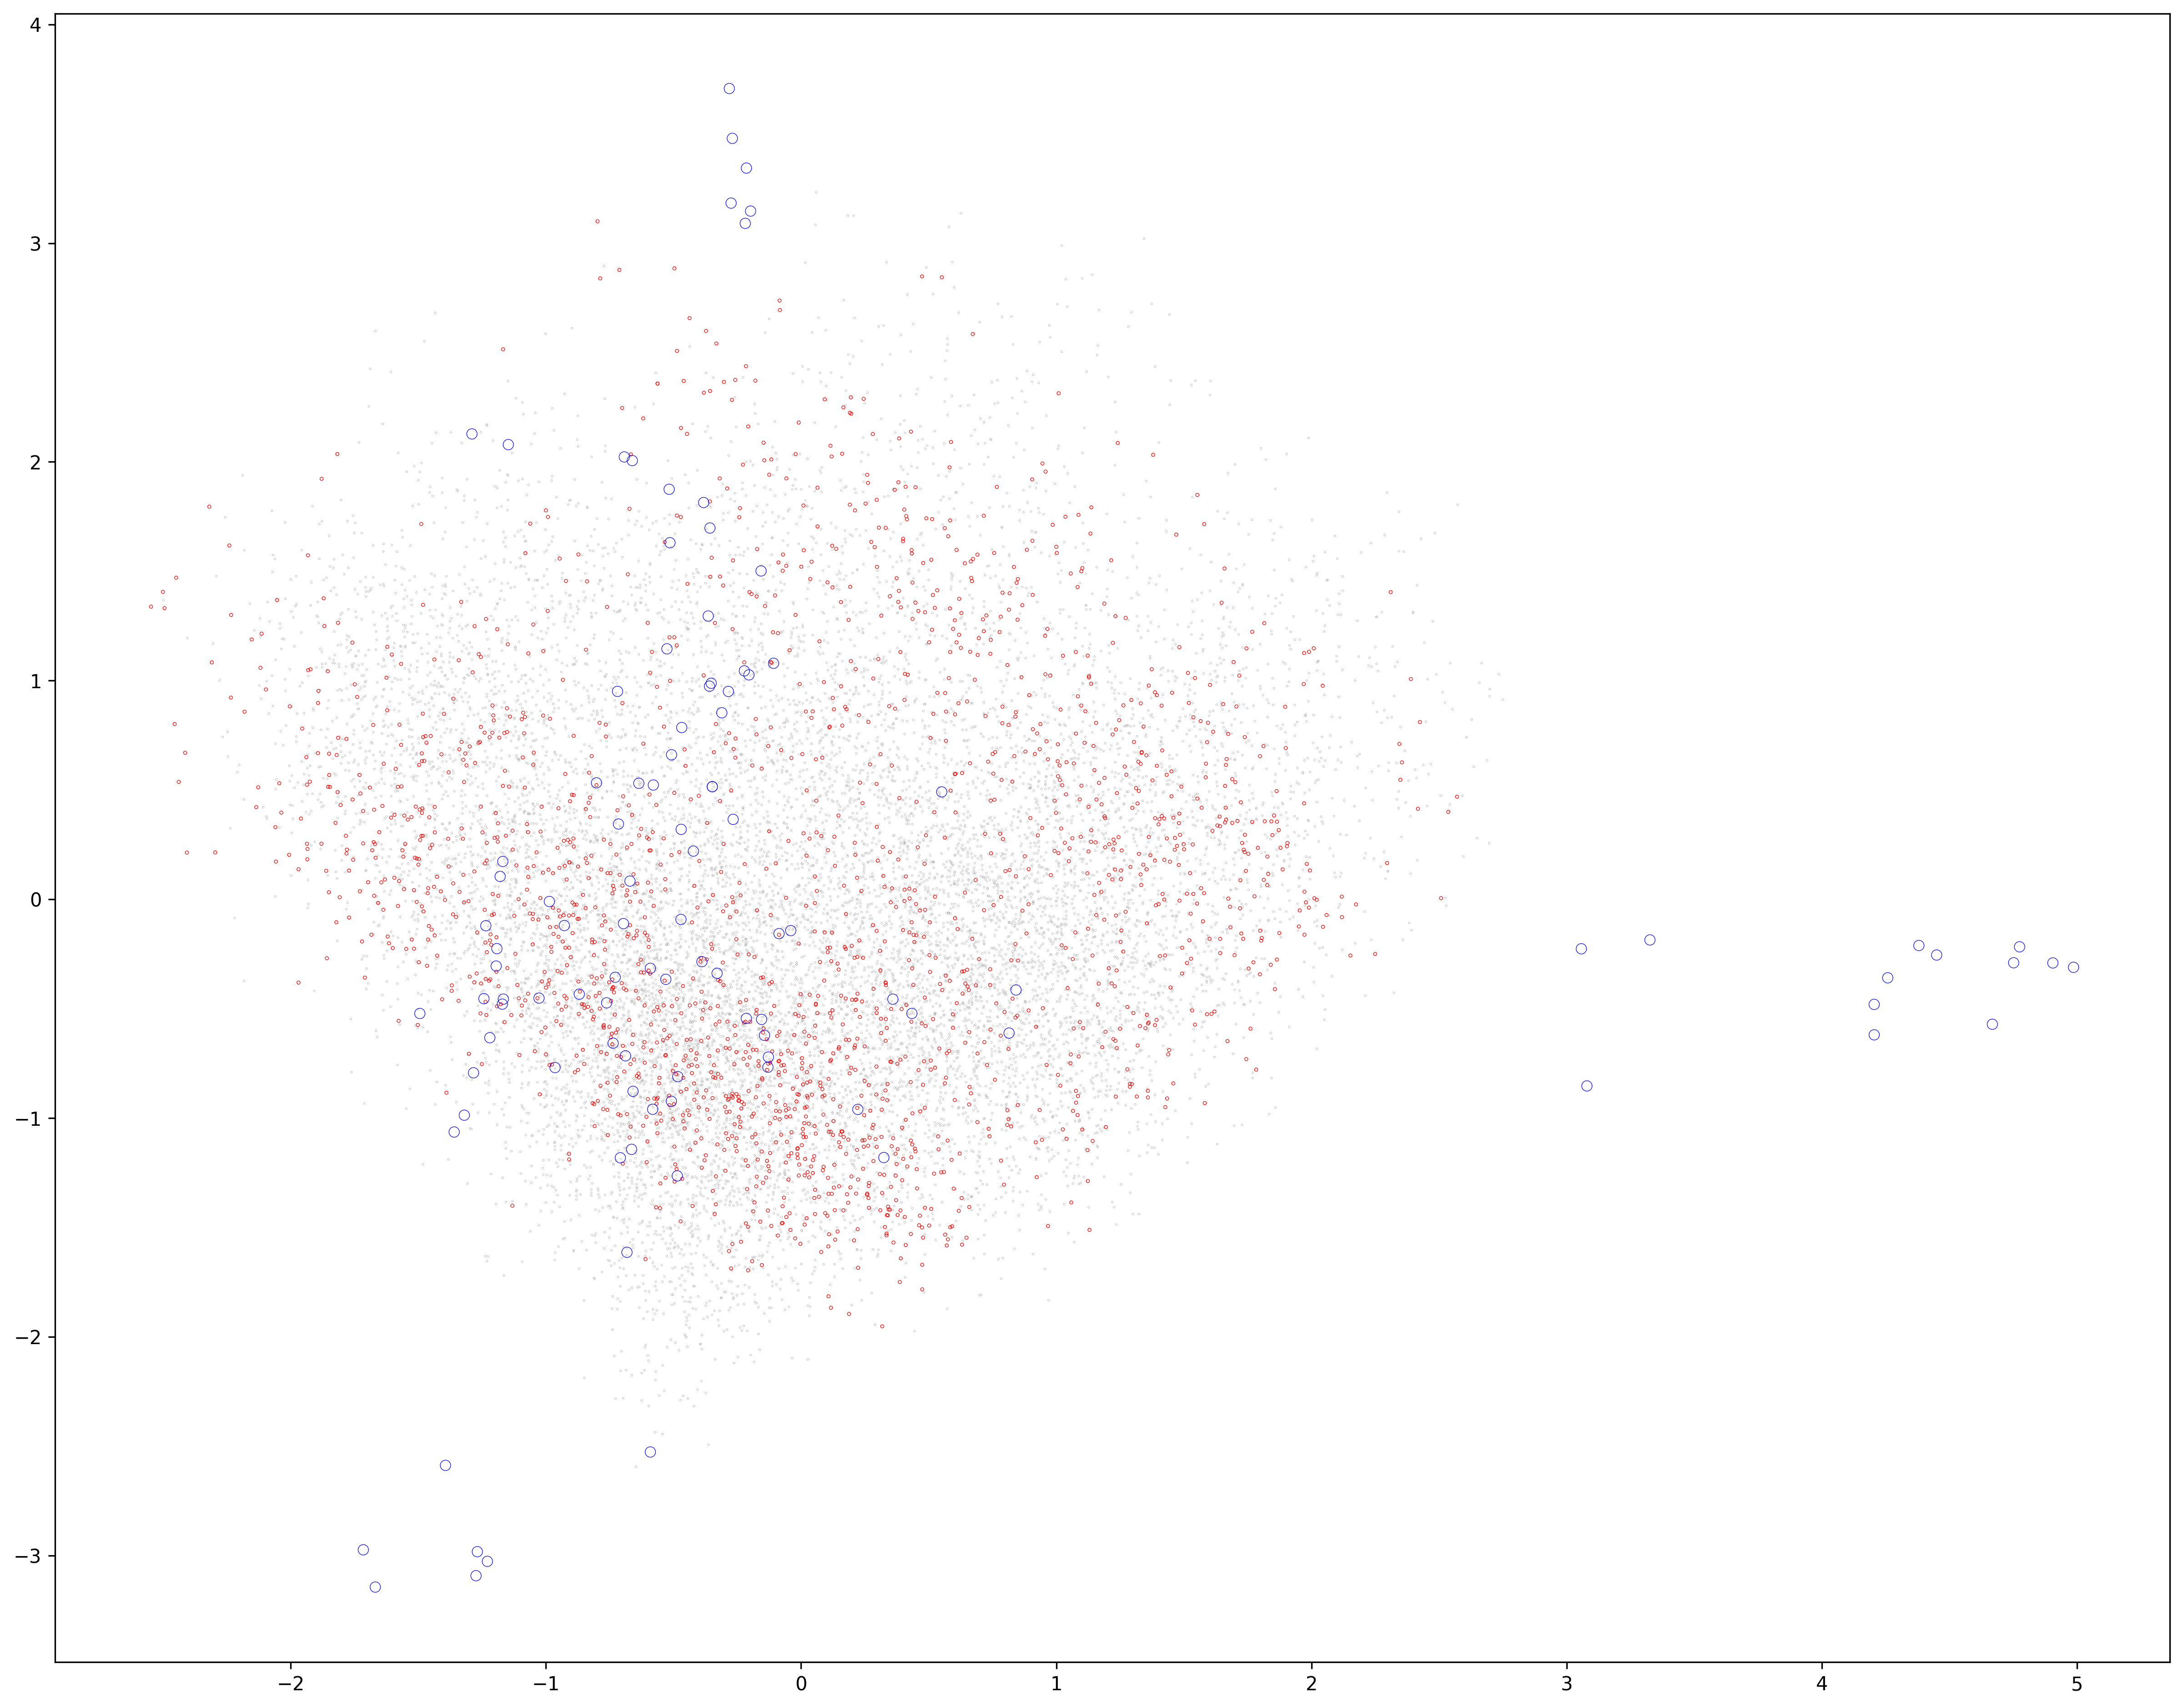

In [70]:
from matplotlib.pyplot import figure
figure(figsize=(20, 16), dpi=300)

plt.scatter(x = chemicalspace_inc[:, 0], y = chemicalspace_inc[:, 1], s=1, facecolors='none', edgecolors='gray', linewidths=0.1)
plt.scatter(x = chemicalspace_inac[:, 0], y = chemicalspace_inac[:, 1], s=3, facecolors='none', edgecolors='r', linewidths=0.3)
plt.scatter(x = chemicalspace_act[:, 0], y = chemicalspace_act[:, 1], s=30, facecolors='none', edgecolors='b', linewidths=0.3)

* We can see that inconclusive molecules are sparse above the chemical space and do not form any clusters. The same for the inactives (red circles), except for some small clusters inside the mass. 

* We can see that there are 3 active clusters. Anyway, they are in fact a little small one. For my surprise, there are active molecules remarkably close to inactive molecules, which is something that I did not expect.  

* It can be considered new active molecules to those inconclusive molecules near to some active molecule, where there aren't inactive molecules and its pChEMBL value is higher than the mean of the active molecules. 

There are approx. 25 molecules with active label that are forming clusters outside of the centric mass of molecules. Hopefully, our new selection of active molecules from the inconclusive pool will help. 

## Selection of new active molecules 

The selection of actives from the inconclusive ones is going to be carried out using the criteria: 

* At least 0.7 Tanimoto similarity 

* At maximum of 0.95, to ensure some diversity 

* Its activity needs to be bigger than the active molecule compared to 

* There cannot be an inactive molecule more similar than the closest active molecule. 

### Preparing the molecules used to compare

To distinguish from inconclusives from the inactive molecules, there will be only used those truly inactive molecules with a pChEMBL value lower than 4.5.

In [75]:
# ACTIVE
smiles_act = df_act.values[:, 0]
fps_act = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_act]

# INACTIVE
inactives = df_inac['pChEMBL_Value'] <= 4.5
df_inac_filt = df_inac[inactives]
smiles_inac = df_inac_filt.values[:, 0]
fps_inac = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_inac]

# INCONCLUSIVE
pseudo_actives = df_inc['pChEMBL_Value'] >= 5.5
df_inc_filt = df_inc[pseudo_actives]
smiles_inc = df_inc_filt.values[:, 0]
fps_inc = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_inc]

### Algoritm to select molecules with more chances to be active

In [83]:
from rdkit import DataStructs

new_positives_indices = []
for i, fp_active in enumerate(fps_act):
    print(f'Estamos en la molecula activa numero { i + 1 }')
    candidates_from_pseudoactives = []
    for e, fp_candidate in enumerate(fps_inc):
        tn = DataStructs.FingerprintSimilarity(fp_active, fp_candidate)
        similarity_diversity_criteria = (tn >= 0.7) & (tn <= 0.95)
        candidate_activity_criteria = df_inc_filt.values[:, 1][e] >= df_act.values[:, 1][i]
        
        if similarity_diversity_criteria and candidate_activity_criteria:
            # print(f'Tenemos un candidato')
            candidates_from_pseudoactives.append((fp_candidate, e, tn))

    for a, candidate in enumerate(candidates_from_pseudoactives):
        fp_candidate, e, tn_active = candidate
        candidate_act_similarity_criteria = True

        for u, fp_inactive in enumerate(fps_inac):
            tn_inac = DataStructs.FingerprintSimilarity(fp_inactive, fp_candidate)
            candidate_act_similarity_criteria = tn_active > tn_inac

            if not candidate_act_similarity_criteria:
                break

        if candidate_act_similarity_criteria:
            # print('Nueva molecula activa')
            new_positives_indices.append(e)



Estamos en la molecula activa numero 1
Estamos en la molecula activa numero 2
Estamos en la molecula activa numero 3
Estamos en la molecula activa numero 4
Estamos en la molecula activa numero 5
Estamos en la molecula activa numero 6
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Tenemos un candidato
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Nueva molecula activa
Estamos en la molecula activa numero 7
Tenemos un candidato
Tenemos un candidato
Nueva molecula activa
Nueva molecula activa
Estamos en la molecula activa numero 8
Estamos en la molecula activa numero 9
Esta

## TODO
Same aproach to select new inactve molecules from the inconclusive pools. Since there are lot more inactive molecules covering the same places that inconclusives, from this aproach will raise much more inactive molecules.

In [1]:
# TODO

## Saving the molecules datasets

### Saving the new active molecules

In [90]:
# Delete duplicate molecules since the same inconclusive molecule can be near to two active molecules. 
values = list(set(new_positives_indices))

smiles_inc_to_postive = df_inc_filt.values[values, 0]
df_inc_to_postive = pd.DataFrame({'Smiles':smiles_inc_to_postive}).sample(frac=1).assign(is_active = 1)
df_inc_to_postive.to_csv('./procesed/inconclusives/new_positives.csv', index=False)

### Saving the active and inactive molecules

In [101]:
# ACTIVE
actives_final_df = df_act.sample(frac=1).assign(is_active = 1)[['Smiles', 'is_active']].reset_index(drop=True)
actives_final_df.to_csv('./procesed/actives/final_actives.csv', index=False)

# INACTIVE
inactives_final_df = df_inac.sample(frac=1).assign(is_active = 0)[['Smiles', 'is_active']].reset_index(drop=True)
inactives_final_df.to_csv('./procesed/inactives/final_inactives.csv', index=False)

In [4]:
import pandas as pd

# Dataset for training and testing preparation

## Reading the files

In [5]:
df_actives = pd.read_csv('./procesed/actives/final_actives.csv')
df_inactives = pd.read_csv('./procesed/inactives/final_inactives.csv')
df_new_positives = pd.read_csv('./procesed/inconclusives/new_positives.csv')

print(f'There are {len(df_actives) + len(df_new_positives)} active molecules in the dataset')
print(f'There are {len(df_inactives)} inactive molecules in the dataset')


There are 203 active molecules in the dataset
There are 4681 inactive molecules in the dataset


In [ ]:
# .sample(frac = 1) is for shuffle the data
df_concat = pd.concat([df_actives, df_inactives, df_new_positives]).sample(frac=1).sample(frac=1).sample(frac=1).sample(frac=1).reset_index(drop=True)
df_concat_wo_dup = df_concat.drop_duplicates(subset=['Smiles'])

## Spliting the dataset for training and teting with sklearn

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df = df_concat_wo_dup.sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1)

# Spliting the data
df_train, df_test = train_test_split(df, test_size=0.2)

print(f'There are {len(df)} molecules in the dataset')
print(f'There are {len(df_train)} molecules in training dataset')
print(f'There are {len(df_test)} molecules in test dataset')

There are 4881 molecules in the dataset
There are 3904 molecules in training dataset
There are 977 molecules in test dataset


### Oversampling the training dataset 

At the end, I decided to not oversample the active molecules and consider the imbalance during the training in the loss function. 

In [10]:
df = df_train.copy()
df = df.sample(frac=1).sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print('Oversampling active ones')

# Actives
df_active = df[active].sample(frac=2, replace=True)

# Inactives
df_inactive = df[inactive].sample(frac=1)

# Concatening
df = pd.concat([df_active, df_inactive]).sample(frac=1).sample(frac=1).sample(frac=1)

# Analizing again the active an inactive molecules
active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/training_ds.csv', index=False)

Ther are 161 different active molecules
Ther are 3743 different inactive molecules
Oversampling active ones
Ther are 322 different active molecules
Ther are 3743 different inactive molecules
 - - - - - - - - - - - - 


### Saving the test set

In [11]:
df = df_test.copy()
df = df.sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/test_ds.csv', index=False)

Ther are 39 different active molecules
Ther are 938 different inactive molecules


### Creating and saving a dummy training set

In [12]:
df_actives = df[active]
num_actives = len(df_actives)

df_inactives = df[inactive].sample(num_actives)

# Concatening
df_dummy_training = pd.concat([df_actives, df_inactives]).sample(frac=1).sample(frac=1).sample(frac=1)
df_dummy_training.to_csv('./data_for_training_and_testing/dummy_training_ds.csv', index=False)

---

## Actives + Inconclusives + Decoys

Decoy molecules were generated with DUD-E to enhance the feature extraction from the molecules. As seen in this paper, this approach is used to make benchmark dataset, since this approach test the models in its performance to distinguish between active molecules from similar inactive molecules without bias. 

* Réau M, Langenfeld F, Zagury J-F, Lagarde N and Montes M (2018) Decoys Selection in Benchmarking Datasets: Overview and Perspectives. Front. Pharmacol. 9:11. doi: 10.3389/fphar.2018.00011

Decoys were generated from the active molecules.

In [15]:
df_actives = pd.read_csv('./procesed/actives/final_actives.csv')
df_decoys = pd.read_csv('./procesed/actives/decoys/decoy_final.csv')
df_inactives = pd.read_csv('./procesed/inactives/final_inactives.csv')
df_new_positives = pd.read_csv('./procesed/inconclusives/new_positives.csv')

print(f'There are {len(df_actives) + len(df_new_positives)} active molecules in the dataset')
print(f'There are {len(df_inactives) + len(df_decoys)} inactive molecules in the dataset')

There are 203 active molecules in the dataset
There are 5246 inactive molecules in the dataset


In [16]:
df_concat = pd.concat([df_actives, df_decoys, df_inactives, df_new_positives]).sample(frac=1).sample(frac=1).sample(frac=1).sample(frac=1).reset_index(drop=True)
df_concat_wo_dup = df_concat.drop_duplicates(subset=['Smiles'])

In [17]:
df = df_concat_wo_dup.sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1)

# Spliting the data
df_train, df_test = train_test_split(df, test_size=0.2)

print(f'There are {len(df)} molecules in the dataset')
print(f'There are {len(df_train)} molecules in training dataset')
print(f'There are {len(df_test)} molecules in test dataset')


There are 5446 molecules in the dataset
There are 4356 molecules in training dataset
There are 1090 molecules in test dataset


In [20]:
df = df_train.copy()
df = df.sample(frac=1).sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print('Oversampling active ones')

# Actives
# NOT OVERSAMPLING
df_active = df[active].sample(frac=1, replace=True)

# Inactives
df_inactive = df[inactive].sample(frac=1)

# Concatening
df = pd.concat([df_active, df_inactive]).sample(frac=1).sample(frac=1).sample(frac=1)

# Analizing again the active an inactive molecules
active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print(' - - - - - - - - - - - - ')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/act_inc_dec/training_wdec_ds.csv', index=False)

Ther are 163 different active molecules
Ther are 4193 different inactive molecules
Oversampling active ones
Ther are 163 different active molecules
Ther are 4193 different inactive molecules
 - - - - - - - - - - - - 


In [19]:
df = df_test.copy()
df = df.sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

#df['is_active'] = np.where(df['pChEMBL Value'] >= active_cutoff, 1, 0)
df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/act_inc_dec/test_wdec_ds.csv', index=False)

Ther are 37 different active molecules
Ther are 1053 different inactive molecules


# Training the model. 
A DNN is proposed first, but an GNN will be also implemented. The model was optimizated using Optuna.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install rdkit-pypi

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 48.6 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 52.7 MB/s 
     |████████████████████████████████| 149 kB 57.2 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8f389ceb3f9b559fe6be80208bfa9a1840762cfcb3b4df30d6db5e6457b63ad4
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 20.6 MB 6.2 MB/s 


## DNN
Morganfp were generated using Rdkit and used as input. NN was constructed dinamicaly to find the best configuration using optuna. The best parameters were:


For mk
```
{
'batch_size': 111, 
'fp_size': 2000, 
'lr': 0.002222696558416456, 
'num_hidden_layers': 2, 
'seq_init_out': 3000, 
'dropout': 0.55
}
```

Device is: cuda
Epoch 0
loss 1.4376 | precision_score 0.0844 | matthews_corrcoef 0.1831 | accuracy 0.6687
loss 8.9271 | precision_score 0.4545 | matthews_corrcoef 0.2345 | accuracy 0.9651

Epoch 2
loss 0.1877 | precision_score 0.4278 | matthews_corrcoef 0.6304 | accuracy 0.9502
loss 0.7966 | precision_score 0.2542 | matthews_corrcoef 0.4239 | accuracy 0.9128

Epoch 4
loss 0.0709 | precision_score 0.7352 | matthews_corrcoef 0.8459 | accuracy 0.9862
loss 1.1152 | precision_score 0.5490 | matthews_corrcoef 0.6302 | accuracy 0.9706

Epoch 6
loss 0.0259 | precision_score 0.9056 | matthews_corrcoef 0.9497 | accuracy 0.9961
loss 1.0889 | precision_score 0.5957 | matthews_corrcoef 0.6586 | accuracy 0.9743

Epoch 8
loss 0.0242 | precision_score 0.8859 | matthews_corrcoef 0.9388 | accuracy 0.9952
loss 1.4228 | precision_score 0.5778 | matthews_corrcoef 0.6232 | accuracy 0.9725

Epoch 10
loss 0.0129 | precision_score 0.9314 | matthews_corrcoef 0.9637 | accuracy 0.9972
loss 1.4284 | precision_scor

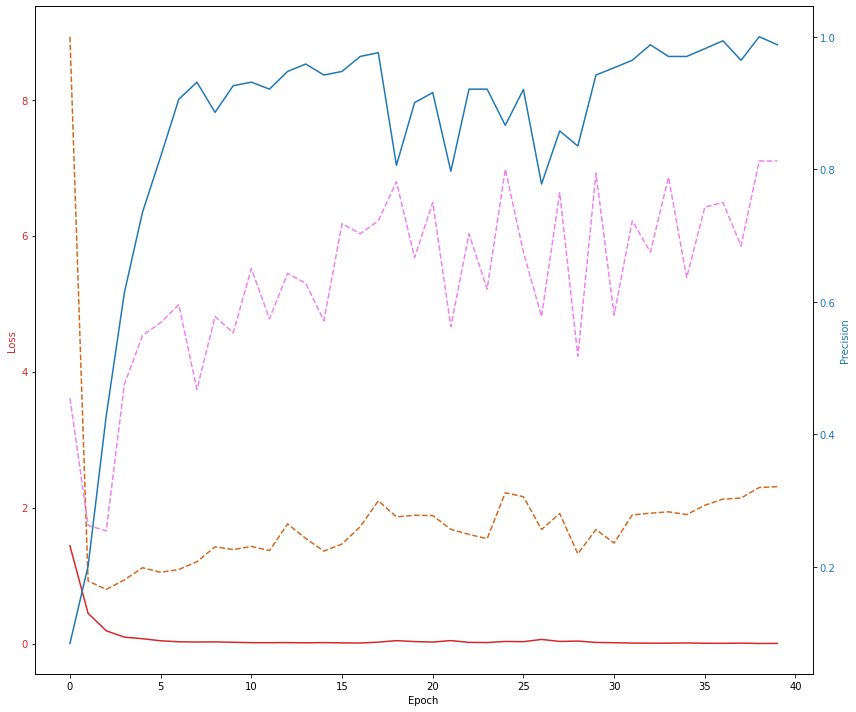

In [ ]:
from sklearn.metrics import precision_score, matthews_corrcoef, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rdkit.Chem as Chem
from rdkit.Chem import AllChem

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')

class fpDataset(Dataset):
    def __init__(self, file_name, fp_size):
        self.data = pd.read_csv(file_name).values
        self.fp_size = fp_size
        self.postives = np.sum(self.data[:, 1])
        print(f'The dataset contains {self.data} molecules with a total of {self.positives} active molecules')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles, y = self.data[idx, :]
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol, radius=2, nBits=self.fp_size)
        x = np.array(fp, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        return x, y


class fpModel(nn.Module):
    def __init__(self, num_hidden_layers, fp_size, seq_init_out, dropout):
        super(fpModel, self).__init__()
        self.drop = torch.nn.Dropout(p=dropout)
        self.seq_init = nn.Sequential(
            nn.Linear(fp_size, seq_init_out),
            nn.Dropout(p=dropout),
            nn.ReLU(),
        )

        self.middle_module_list = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.middle_module_list.append(
                nn.Linear(seq_init_out, seq_init_out))
            self.middle_module_list.append(
                nn.BatchNorm1d(num_features=seq_init_out))
            self.middle_module_list.append(nn.ReLU())
            self.middle_module_list.append(self.drop)

        self.middle_module = nn.Sequential(*self.middle_module_list)

        self.out_module = nn.Sequential(
            nn.Linear(seq_init_out, 1),
        )

    def forward(self, x):
        x = self.seq_init(x)
        x = self.middle_module(x)
        x = self.out_module(x)

        return x


def get_metrics(y_true, y_pred):
    y_pred = np.rint(y_pred)

    precision = precision_score(y_true, y_pred)
    matthews = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, matthews, accuracy


def training_step(model, x, y_target, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    h = model(x)

    loss = criterion(h.reshape(-1), y_target.reshape(-1))
    loss.backward()

    optimizer.step()

    return float(loss), h


@torch.no_grad()
def test_step(model, x, y_target, criterion):
    model.eval()

    h = model(x)

    loss = criterion(h, y_target)

    return float(loss), h


def epoch(model, dataloader, criterion, optimizer, training=True):

    total_loss = 0
    total_examples = 0

    y_target_list = []
    h_list = []

    for x, y_target in dataloader:
        x, y_target = x.to(DEVICE), y_target.to(DEVICE)

        y_target = y_target.reshape(-1, 1)

        if training:
            loss, h = training_step(model, x, y_target, criterion, optimizer)
        else:
            loss, h = test_step(model, x, y_target, criterion)

        total_loss += loss * len(y_target)
        total_examples += len(y_target)

        y_target_list.append(y_target)
        h_list.append(h)

    y_true = torch.cat(y_target_list, dim=0).detach().cpu().numpy()
    y_pred = torch.sigmoid(torch.cat(h_list, dim=0)).detach().cpu().numpy()

    precision_score, matthews_corrcoef, accuracy = get_metrics(y_true, y_pred)

    return total_loss/total_examples, precision_score, matthews_corrcoef, accuracy


def training_init(EPOCHS, model, dataloaders, criterion, optimizer):
    train_metrics = []
    test_metrics = []

    train_dataloader, test_dataloader = dataloaders

    for e in range(EPOCHS):
        train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = epoch(
            model, train_dataloader, criterion, optimizer)
        train_metrics.append([train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy])

        test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = epoch(
            model, test_dataloader, criterion, optimizer, training=False)
        test_metrics.append([test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy])

        if e % 2 == 0:
            print(f'Epoch {e}')
            print(f'loss {train_total_loss:.4f} | precision_score {train_precision_score:.4f} | matthews_corrcoef {train_matthews_corrcoef:.4f} | accuracy {train_accuracy:.4f}')
            print(f'loss {test_total_loss:.4f} | precision_score {test_precision_score:.4f} | matthews_corrcoef {test_matthews_corrcoef:.4f} | accuracy {test_accuracy:.4f}')
            print()

    return test_precision_score, (train_metrics, test_metrics)


# OPTUNA PART
# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_model_criterion_optimizer(weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout):
    model = fpModel(num_hidden_layers, fp_size, seq_init_out, dropout)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

# TODO: This can be refactorized to delete this function
def get_model_criterion_optimizer_for_optuna(trial, weight, fp_size):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 12, step=2)
    seq_init_out = trial.suggest_int('seq_init_out', 1000, 3000, step=500)
    dropout = trial.suggest_float("dropout", 0.4, 0.8, step=0.05)
    return get_model_criterion_optimizer(weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout)

# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_dataset_and_weight(file_name, fp_size, batch_size, shuffle=True):
    train_dataset = fpDataset(file_name, fp_size=fp_size)
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle)
    weight = len(train_dataset) / train_dataset.postives
    weight = torch.Tensor([weight])
    return train_dataloader, weight



# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_all_optuna(trial, fp_size, file_name, batch_size, shuffle=True):
    dataloader, weight = get_dataset_and_weight(file_name, fp_size, batch_size, shuffle=shuffle)

    model, criterion, optimizer = get_model_criterion_optimizer_for_optuna(
        trial, weight, fp_size)

    return model, criterion, optimizer, dataloader

# Best parameters. Some were changed since in training did not work to well


# Data
if __name__ == '__main__':
    batch_size_train = 120
    batch_size_test = 40
    fp_size = 2000

    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv' # wdec: with decoys + posible_actives_from_inconclusives
    # train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_ampc.csv' # ampc: without decoys + posible_actives_from_inconclusives
    train_dataloader, weight = get_dataset_and_weight(
        train_file_name, fp_size, batch_size_train, shuffle=True)

    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_wdec_ds.csv' # wdec: with decoys + posible_actives_from_inconclusives
    # test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_ampc.csv' # ampc: without decoys + posible_actives_from_inconclusives
    test_dataloader, _ = get_dataset_and_weight(
        test_file_name, fp_size, batch_size_test, shuffle=False)

    num_hidden_layers = 2
    seq_init_out = 3000
    dropout = 0.55
    lr = 0.0005222696558416456
    model, criterion, optimizer = get_model_criterion_optimizer(
        weight, lr, fp_size, num_hidden_layers, seq_init_out, dropout)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 40
    _, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)
    
    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    #AX1
    fig, ax1 = plt.subplots(figsize=(12,10))
    #figure(figsize=(18, 16), dpi=300)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Loss
    t = range(EPOCHS)
    ax1.plot(t, train_total_loss, color='tab:red')
    ax1.plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # AX2
    # Presicion
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Precision', color='tab:blue')  
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax2.plot(t, train_precision_score, color='tab:blue')
    ax2.plot(t, test_precision_score, color='violet', linestyle='dashed')

    fig.tight_layout() 
    plt.show()


The dataset overfits to fast in epoch 3-4 but presicion continue increasing until 0.8. Also the matthews_corrcoef increase, meaning that the model is learning.

# Optuna

In [ ]:
import torch
import optuna
import pandas as pd
from optuna.trial import TrialState


## Optimization for DNN

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')

def objective_fp(trial):

    EPOCHS = 12
    batch_size = trial.suggest_int('batch_size', 111, 511, step=100)
    fp_size = trial.suggest_int('fp_size', 1000, 2000, step=500)

    # Training
    file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_mk.csv'
    model, criterion, optimizer, train_dataloader = get_all_optuna(
        trial, fp_size, file_name, batch_size=batch_size, shuffle=True)
    # Testing
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv'
    test_dataloader, _ = get_dataset_and_weight(
        test_file_name, fp_size, batch_size, shuffle=False)

    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    test_precision_score, _ = training_init(
        EPOCHS, model, [train_dataloader, test_dataloader], criterion, optimizer)

    return test_precision_score

# Code inspired from optuna documentation examples
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


## Optimization for GNN

Code taken from the DeepChem book 
* Bharath Ramsundar, Peter Eastman, Patrick Walters, Vijay Pande - Deep Learning for the Life Sciences_ Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More-O’Reilly Media (2019)

In [ ]:
# GPU version
!pip install tqdm
!pip install tensorflow~=2.4
!pip install deepchem

     |████████████████████████████████| 552 kB 4.2 MB/s 


In [ ]:
from rdkit.Chem import AllChem
import pandas as pd

# path_dummy = './data_for_training_and_testing/training_ds.csv'
# df = pd.read_csv(path_dummy)

import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

To be honest, I dont get much of the code from the book, but i will try any way since it is easy to implement and tune with optuna. Also, I've implemented a GNN with PyG by my own, but I still have to merge the code with this notebook ant adapt it to hypterparameter tunning with optuna, so it is a TODO. There is a preview code but is not finished.

In [ ]:
'''
dropout: float = 0.0, 
batch_size: int = 100, 
graph_conv_layers: List[int] = [64, 64], 
dense_layer_size: int = 128, 
number_atom_features: int = 75
'''
# n_tasks: int, 
# mode: str = 'classification', 
# n_classes: int = 2, 
# batch_normalize: bool = True

def generate_graph_conv_model(dropout, batch_size, graph_conv_layers, dense_layer_size, number_atom_features):
    model = GraphConvModel(1, dropout = dropout, batch_size=batch_size, graph_conv_layers=[graph_conv_layers,graph_conv_layers], dense_layer_size=dense_layer_size, number_atom_features=number_atom_features, mode='classification', model_dir="./model_dir")
    return model


def training(trial, cv_folds, dataset_file):

    # Model parameters
    dropout = trial.suggest_float("dropout", 0.4, 0.7, step=0.05)
    batch_size = trial.suggest_int('batch_size', 100, 200, step=100)
    graph_conv_layers = trial.suggest_int('graph_conv_layers', 32, 256, step=32)
    dense_layer_size = trial.suggest_int('dense_layer_size', 10, 510, step=100)
    number_atom_features = trial.suggest_int('number_atom_features', 40, 900, step=10)

    tasks = ["is_active"]
    featurizer = dc.feat.ConvMolFeaturizer()
    loader = dc.data.CSVLoader(tasks=tasks, feature_field="Smiles", featurizer=featurizer)
    dataset = loader.create_dataset(dataset_file, shard_size=8192)

    splitter = dc.splits.RandomSplitter()
    metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

    training_score_list = []
    validation_score_list = []
    transformers = []

    for i in tqdm(range(0,cv_folds)):
        model = generate_graph_conv_model(dropout, batch_size, graph_conv_layers, dense_layer_size, number_atom_features)
        train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
        model.fit(train_dataset)
        train_scores = model.evaluate(train_dataset, metrics, transformers)
        training_score_list.append(train_scores["mean-matthews_corrcoef"])
        validation_scores = model.evaluate(valid_dataset, metrics, transformers)
        validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
    
    print(training_score_list)
    print(validation_score_list)

    return max(validation_score_list), [training_score_list, validation_score_list]




## Optuna optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def objective_fp(trial):

    cv_folds = 5
    file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv'

    # Training
    matthews_corrcoef, _ = training(trial, cv_folds, file_name)

    return matthews_corrcoef

# Code inspired from optuna documentation examples
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



[I 2021-11-21 21:55:34,758] A new study created in memory with name: no-name-456abf6d-4c4e-4aa6-9ecb-671f77231a2f


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:02:21,039] Trial 0 finished with value: 0.3666557420110231 and parameters: {'dropout': 0.4, 'batch_size': 200, 'graph_conv_layers': 224, 'dense_layer_size': 110, 'number_atom_features': 580}. Best is trial 0 with value: 0.3666557420110231.


[0.31142327293666333, 0.3252938781556216, 0.0887806743234052, 0.3820428730342298, 0.3512757756433789]
[0.09909432385056663, 0.2458823949482132, 0.010929536002687376, 0.1639456653932076, 0.3666557420110231]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:08:32,020] Trial 1 finished with value: 0.5387729475023668 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 160, 'dense_layer_size': 310, 'number_atom_features': 710}. Best is trial 1 with value: 0.5387729475023668.


[0.4381188739990235, 0.42813393534625765, 0.4499707172797226, 0.3707002271803531, 0.43862938157429837]
[0.4730739101462069, 0.4114989568638858, 0.20087210141148906, 0.15153368870560166, 0.5387729475023668]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:12:53,738] Trial 2 finished with value: 0.6185326925533262 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 64, 'dense_layer_size': 310, 'number_atom_features': 430}. Best is trial 2 with value: 0.6185326925533262.


[0.35132724708808594, 0.41555356147932365, -0.0033091562315908287, 0.3999407869998277, 0.25645365298273365]
[0.0, 0.3699768545282051, -0.011420308290053941, 0.6185326925533262, 0.0]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:18:59,032] Trial 3 finished with value: 0.39612293317854486 and parameters: {'dropout': 0.6000000000000001, 'batch_size': 100, 'graph_conv_layers': 128, 'dense_layer_size': 410, 'number_atom_features': 760}. Best is trial 2 with value: 0.6185326925533262.


[0.26716876810574836, 0.3227950172266563, 0.17563882284663118, 0.3005377654854667, 0.10130931090312363]
[0.10449267622589367, 0.39612293317854486, 0.16245952444715636, 0.3466084835602096, 0.29960790893583633]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:24:37,097] Trial 4 finished with value: 0.46015041847250016 and parameters: {'dropout': 0.5, 'batch_size': 200, 'graph_conv_layers': 128, 'dense_layer_size': 310, 'number_atom_features': 560}. Best is trial 2 with value: 0.6185326925533262.


[0.008498171981341292, 0.354538667303903, 0.3218216914001759, 0.14107840495777685, 0.275491715588087]
[0.0, 0.2660799204900621, 0.46015041847250016, 0.22916733139243078, 0.24875203627196815]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:30:34,510] Trial 5 finished with value: 0.30462519936204147 and parameters: {'dropout': 0.7, 'batch_size': 100, 'graph_conv_layers': 96, 'dense_layer_size': 510, 'number_atom_features': 130}. Best is trial 2 with value: 0.6185326925533262.


[0.11068179795142556, 0.07760079476983604, -0.006754278753035485, 0.17700900435948627, 0.1984115758924944]
[0.035752028795694994, 0.04492045598139898, 0.10489250989106286, 0.288744856381007, 0.30462519936204147]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:36:55,785] Trial 6 finished with value: 0.3491605795718848 and parameters: {'dropout': 0.65, 'batch_size': 200, 'graph_conv_layers': 96, 'dense_layer_size': 510, 'number_atom_features': 560}. Best is trial 2 with value: 0.6185326925533262.


[0.08834770155009081, 0.07519972754436026, 0.2017417406613238, 0.19151064231232537, 0.15866937328113306]
[0.08048381856548995, 0.10369061564714453, 0.19276221332275825, 0.3491605795718848, 0.22026141230982696]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:42:35,088] Trial 7 finished with value: 0.22958475325003155 and parameters: {'dropout': 0.55, 'batch_size': 200, 'graph_conv_layers': 128, 'dense_layer_size': 210, 'number_atom_features': 740}. Best is trial 2 with value: 0.6185326925533262.


[0.3508706340196287, 0.057058030122811146, 0.43077493702220787, 0.13654079743409328, 0.3197586846128415]
[0.22958475325003155, 0.05960270128742373, 0.05900199116224357, 0.2125378436027871, 0.18715773373420289]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:48:02,475] Trial 8 finished with value: 0.22540204719841214 and parameters: {'dropout': 0.65, 'batch_size': 100, 'graph_conv_layers': 192, 'dense_layer_size': 10, 'number_atom_features': 550}. Best is trial 2 with value: 0.6185326925533262.


[0.06903546416686789, 0.014909171990204504, 0.21946027896143042, 0.15776680307044305, 0.007484811885651197]
[0.015477736296523673, -0.01090549219462522, 0.15952200078742032, 0.22540204719841214, -0.030641885618414372]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:53:05,333] Trial 9 finished with value: 0.4372653339429707 and parameters: {'dropout': 0.5, 'batch_size': 100, 'graph_conv_layers': 96, 'dense_layer_size': 310, 'number_atom_features': 730}. Best is trial 2 with value: 0.6185326925533262.


[0.45355406440562435, 0.303386250191383, 0.2752526235863547, 0.20321001526131685, 0.1973015391644003]
[0.3830291508053092, 0.2360293298714918, 0.4372653339429707, 0.0, 0.3017758862777668]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 22:56:16,768] Trial 10 finished with value: 0.507957567321401 and parameters: {'dropout': 0.4, 'batch_size': 100, 'graph_conv_layers': 32, 'dense_layer_size': 110, 'number_atom_features': 280}. Best is trial 2 with value: 0.6185326925533262.


[0.4070783695974446, 0.4384387178764624, 0.37594467402005854, 0.3747863117459623, 0.11105551162848569]
[-0.013969968905677815, 0.34924682726800554, 0.507957567321401, 0.47389255336829644, 0.3238656100986309]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:00:08,869] Trial 11 finished with value: 0.5321268887870542 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 32, 'dense_layer_size': 310, 'number_atom_features': 340}. Best is trial 2 with value: 0.6185326925533262.


[0.20868650540319877, 0.3147615421641707, 0.32065536239375547, 0.11399585056305109, 0.38943356804350104]
[0.2310506847028597, -0.008405370549189543, 0.5321268887870542, 0.2632373918468618, 0.40111469009653516]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:07:59,106] Trial 12 finished with value: 0.43745975774567164 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 192, 'dense_layer_size': 410, 'number_atom_features': 900}. Best is trial 2 with value: 0.6185326925533262.


[0.383211386017896, 0.42861825685637694, 0.35822325662741417, 0.17818019268152377, 0.26485190787724744]
[0.1438044719065396, 0.43745975774567164, 0.3782146173209342, 0.15676867904733227, 0.19248403378988388]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:18:29,499] Trial 13 finished with value: 0.48121456943911267 and parameters: {'dropout': 0.5, 'batch_size': 100, 'graph_conv_layers': 256, 'dense_layer_size': 210, 'number_atom_features': 370}. Best is trial 2 with value: 0.6185326925533262.


[0.3046077842707793, 0.3325488161480739, 0.2471849681381318, 0.35950765596241246, 0.3142389001169456]
[0.34696035209761994, 0.2071285688306965, 0.134219142285382, 0.48121456943911267, 0.3601174886325737]


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2021-11-21 23:24:09,975] Trial 14 finished with value: 0.5220063697216698 and parameters: {'dropout': 0.45, 'batch_size': 100, 'graph_conv_layers': 64, 'dense_layer_size': 410, 'number_atom_features': 430}. Best is trial 2 with value: 0.6185326925533262.


[0.46342236913019796, 0.3739574533648126, 0.39298872737785145, 0.2633161622340621, 0.42158138291554753]
[0.5220063697216698, 0.15858301525563182, 0.46802924178308264, 0.21866890943621362, 0.3129393463320946]


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip uninstall -y torch torchvision

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install ogb
!pip install rdkit-pypi

     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 407 kB 5.4 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 78 kB 3.5 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=aaf7100f9b0a0fbb9b36486598578c435a754b434327fcb162d80321c8ac43e9
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
     |████████████████████████████████| 20.6 MB 18.2 MB/s 


## Importamos las librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# For Dataset generation and visualization
from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
from ogb.graphproppred.mol_encoder import AtomEncoder
from ogb.utils.features import atom_to_feature_vector, bond_to_feature_vector

# Extras
import os.path as osp
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from math import sqrt


## Dataset visualization

In [ ]:
csv_path = '/content/drive/MyDrive/GNN/ampc/training_ds.csv'
molecules = pd.read_csv(csv_path).sample(10).values

## Data Handling of Graphs

In [3]:
# Pytorch geometric modules
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader

# Torch
import torch

class moleculesDS(InMemoryDataset):
  def __init__(self, root, csv_path, transform=None, pre_transform=None):
    self.csv_path = csv_path
    super().__init__(root, transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return []

  @property
  def processed_file_names(self):
    # After preprocesing usinf comment columns and NOT Decoys
    files = 'final_v2.pt'
    return files


  def download(self):
    pass

  def process(self):
    data_list = []
    molecules = pd.read_csv(self.csv_path).values

    for smiles, act in molecules:
        y = torch.tensor(act, dtype=torch.float32).reshape(-1, 1)
        
        # Throw molecules in wich molecules can not be obtanined
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            mol = None
        if mol is None:
            print('mol is none')
            continue

        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = atom_to_feature_vector(atom)
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        x = torch.tensor(all_node_feats, dtype=torch.long).view(-1, 9)

        edge_attr = []
        edge_index = []
        for bond in mol.GetBonds():

            bond_feats = bond_to_feature_vector(bond)
            edge_attr.append([bond_feats, bond_feats])

            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index += [[i, j], [j, i]]


        edge_attr = torch.tensor(edge_attr)
        edge_attr = edge_attr.to(torch.long).view(-1, 3)

        edge_index = torch.tensor(edge_index)
        edge_index = edge_index.t().to(torch.long).view(2, -1)


        data = Data(x=x, edge_index=edge_index, edge_attr = edge_attr, y=y.reshape(1, 1), smiles=smiles)

        data_list.append(data)

    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])


---

# Model

In [4]:
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

from torch.nn import Sequential, ModuleList, ReLU, Linear, Dropout
import torch.nn.functional as F

from torch_geometric.nn.models import AttentiveFP

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.emb = AtomEncoder(in_channels)
        self.bondemb = BondEncoder(3)

        self.AttentiveFP = AttentiveFP(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1,
                     edge_dim=3, num_layers=num_layers, num_timesteps=1, dropout=dropout)
        
        
    def forward(self, x, edge_index, edge_attr, batch_index):
        x = self.emb(x)
        edge_attr = self.bondemb(edge_attr)
        x = self.AttentiveFP(x, edge_index, edge_attr, batch_index)
        return x

# Training

In [5]:
from sklearn.metrics import precision_score, matthews_corrcoef, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rdkit.Chem as Chem
from rdkit.Chem import AllChem

from statistics import mean

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')


def get_metrics(y_true, y_pred):
    y_pred = np.rint(y_pred)

    precision = precision_score(y_true, y_pred)
    matthews = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, matthews, accuracy


def training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h.reshape(-1), y_target.reshape(-1))
    loss.backward()

    optimizer.step()

    return float(loss), h


@torch.no_grad()
def test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion):
    model.eval()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h, y_target)

    return float(loss), h


def epoch(model, dataloader, criterion, optimizer, training=True):

    total_loss = 0
    total_examples = 0

    y_target_list = []
    h_list = []

    for data in dataloader:
        data = data.to(DEVICE)
        y_target = data.y
        x, edge_index, edge_attr, batch_index = data.x, data.edge_index, data.edge_attr, data.batch

        y_target = y_target.reshape(-1, 1)

        if training:
            loss, h = training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer)
        else:
            loss, h = test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion)

        total_loss += loss * len(y_target)
        total_examples += len(y_target)

        y_target_list.append(y_target)
        h_list.append(h)

    y_true = torch.cat(y_target_list, dim=0).detach().cpu().numpy()
    y_pred = torch.sigmoid(torch.cat(h_list, dim=0)).detach().cpu().numpy()

    precision_score, matthews_corrcoef, accuracy = get_metrics(y_true, y_pred)

    return total_loss/total_examples, precision_score, matthews_corrcoef, accuracy


def training_init(EPOCHS, model, dataloaders, criterion, optimizer):
    train_metrics = []
    test_metrics = []
    test_precision_score_list = []

    train_dataloader, test_dataloader = dataloaders

    for e in range(EPOCHS):
        train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = epoch(
            model, train_dataloader, criterion, optimizer)
        train_metrics.append([train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy])

        test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = epoch(
            model, test_dataloader, criterion, optimizer, training=False)
        test_metrics.append([test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy])
        test_precision_score_list.append(test_precision_score)

        if e % 20 == 0:
            print(f'Epoch {e}')
            print(f'loss {train_total_loss:.4f} | precision_score {train_precision_score:.4f} | matthews_corrcoef {train_matthews_corrcoef:.4f} | accuracy {train_accuracy:.4f}')
            print(f'loss {test_total_loss:.4f} | precision_score {test_precision_score:.4f} | matthews_corrcoef {test_matthews_corrcoef:.4f} | accuracy {test_accuracy:.4f}')
            print()

    # For optimization
    test_precision_score = mean(test_precision_score_list)
    return test_precision_score, (train_metrics, test_metrics)

def get_dataset_and_weight(root, file_name, batch_size, shuffle=True):
    dataset = moleculesDS(root = root, csv_path = file_name)
    loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

    pos_weight = len(dataset.data.y.reshape(-1)) / dataset.data.y.reshape(-1).sum()
    pos_weight = torch.Tensor([pos_weight])
    print(f'El número de valores en el dataset es de: {len(dataset.data.y.reshape(-1))} y tiene {dataset.data.y.sum()} positivos')
    return loader, pos_weight

def get_model_criterion_optimizer(pos_weight, lr, hidden_channels, num_layers, dropout, weight_decay = 1**-6):
    model = GCN(9, hidden_channels, num_layers, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
    return model, criterion, optimizer

# For Optuna
# - - - - - - - - - - - - - - - - - - - - - - - - 
'''
Best trial:
Params: 
    batch_size: 411
    lr: 0.00010701665292432792
    num_layers: 2
    hidden_channels: 220
    dropout: 0.4
'''
'''
Best trial:
  Value:  0.23863636363636365
  Params: 
    batch_size: 411
    lr: 0.005306842152115659
    weight_decay: 1.4144750379298322e-05
    num_layers: 2
    hidden_channels: 120
    dropout: 0.5
'''



def get_model_criterion_optimizer_for_optuna(trial, weight):
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True, )
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 5, step=1)
    hidden_channels = trial.suggest_int('hidden_channels', 20, 520, step=100)
    dropout = 0.5 #trial.suggest_float("dropout", 0.4, 0.6, step=0.1)
    return get_model_criterion_optimizer(weight, lr, hidden_channels, num_layers, dropout, weight_decay = weight_decay)

# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_all_optuna(trial, root, file_name, batch_size, shuffle=True):
    dataloader, weight = get_dataset_and_weight(root, file_name, batch_size, shuffle=shuffle)

    model, criterion, optimizer = get_model_criterion_optimizer_for_optuna(
        trial, weight)

    return model, criterion, optimizer, dataloader

Device is: cuda


El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
El número de valores en el dataset es de: 977 y tiene 37.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9348 | precision_score 0.0774 | matthews_corrcoef -0.0105 | accuracy 0.4770
loss 0.9080 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9454 | precision_score 0.2481 | matthews_corrcoef 0.3303 | accuracy 0.8080
loss 0.7087 | precision_score 0.1351 | matthews_corrcoef 0.2463 | accuracy 0.8240

Epoch 40
loss 0.6859 | precision_score 0.3682 | matthews_corrcoef 0.4908 | accuracy 0.8734
loss 0.5279 | precision_score 0.1824 | matthews_corrcoef 0.3474 | accuracy 0.8516

Epoch 60
loss 0.5381 | precision_score 0.4194 | matthews_corrcoef 0.5607 | accuracy 0.8928
loss 0.4300 | precision_score 0.3061 | matthews_corrcoef 0.4692 | accuracy 0.9232

Epoch 80
loss 0.4001 | precision_score 0.4767 | matthews_corrcoef 0.6199 | accuracy 0.9127
loss 0.4179 | precision_score 0.3649 | matthews_corrcoef 0.4904 | accuracy 0.9417

Epoch 100
loss 0.3084 | precision_score 0.5492 | matthews_corrcoef 0.6895 | accuracy 0.9334
loss 0.4068 | precision_score 0.4203 |

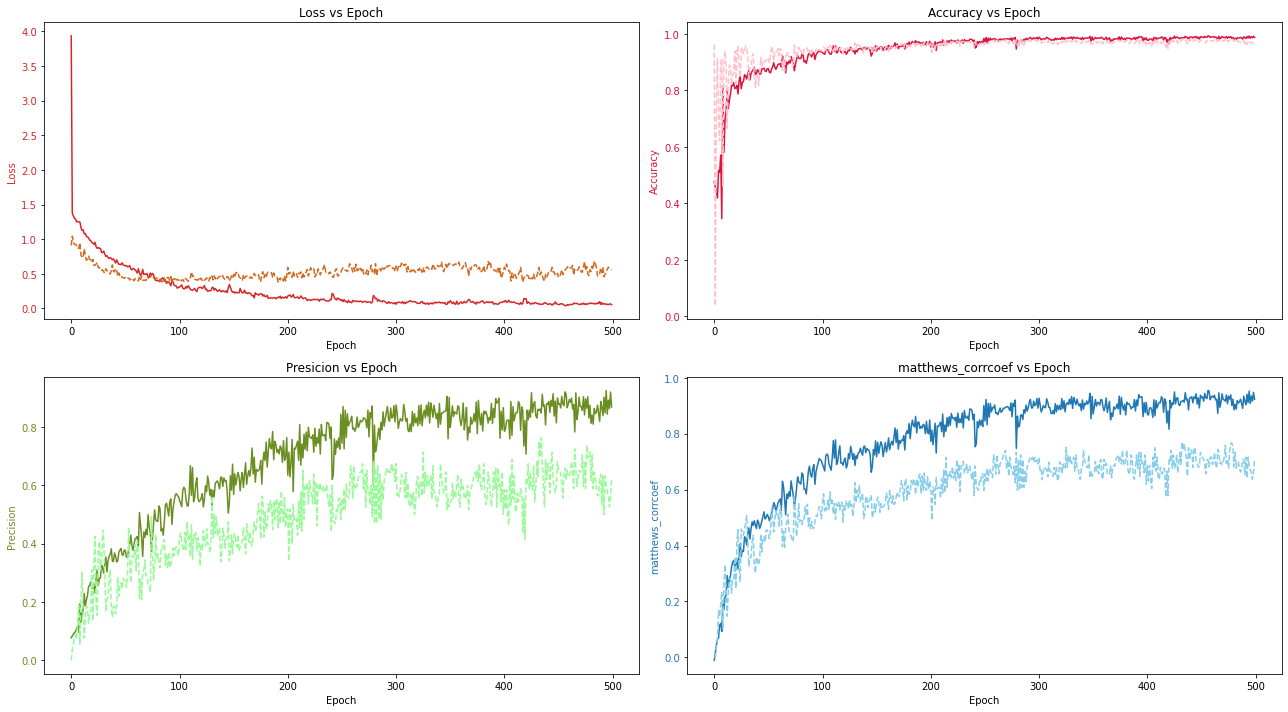

In [14]:
'''
Best trial:
  Value:  0.37037037037037035
  Params: 
    batch_size: 511
    lr: 0.04870277940137615
    weight_decay: 1.0357051478357444e-05
    num_layers: 1
    hidden_channels: 220
    dropout: 0.6
'''
'''
{'batch_size': 511, 
'lr': 0.004932917425534324, 
'weight_decay': 0.001513000379300766, 
'num_layers': 3, 
'hidden_channels': 300, 
'dropout': 0.4}
'''
'''
{
    # ESTABLE
    'batch_size': 411, 
    'lr': 0.0003613844023759524, 
    'weight_decay': 2.2537519543024984e-07, 
    'num_layers': 3, 
    'hidden_channels': 300, 
    'dropout': 0.6000000000000001}. 
'''
'''
Trial 12 finished with value: 
0.2555535528023482 and parameters: 
{'lr': 0.001164884005365969, 
'weight_decay': 3.7540522058417304e-06, 
'num_layers': 2, 
'hidden_channels': 320}. 
'''
'''
Trial 9 finished with value: 
0.21089850679388622 and parameters: 
{'lr': 0.0015294022249668856, 
'weight_decay': 6.502161136338155e-05, 
'num_layers': 2, 
'hidden_channels': 420}. 

'''

if __name__ == '__main__':
    batch_size_train = 500
    batch_size_test = 100

    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_wdec_ds.csv' 
    train_dataloader, weight = get_dataset_and_weight(
        root, train_file_name, batch_size_train, shuffle=True)

    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_wdec_ds.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    num_layers = 2
    hidden_channels = 320
    dropout = 0.5
    lr = 0.0015294022249668856 # learning was inestable, so small rl will be try
    weight_decay = 3.7540522058417304e-06
    model, criterion, optimizer = get_model_criterion_optimizer(
        weight, lr, hidden_channels, num_layers, dropout, weight_decay=weight_decay)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 500
    _, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)
    
    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
    t = range(EPOCHS)


    # Loss
    ax1[0, 0].set_title('Loss vs Epoch')
    ax1[0, 0].set_xlabel('Epoch')
    ax1[0, 0].set_ylabel('Loss', color='tab:red')
    ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
    ax1[0, 0].plot(t, train_total_loss, color='tab:red')
    ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # Presicion
    ax1[1, 0].set_title('Presicion vs Epoch')
    ax1[1, 0].set_xlabel('Epoch')
    ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
    ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

    ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
    ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

    # matthews_corrcoef
    ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
    ax1[1, 1].set_xlabel('Epoch')
    ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
    ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

    ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
    ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

    # Accuracy
    ax1[0, 1].set_title('Accuracy vs Epoch')
    ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
    ax1[0, 1].set_xlabel('Epoch')
    ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

    ax1[0, 1].plot(t, train_accuracy, color='crimson')
    ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

    fig.tight_layout() 
    plt.show()


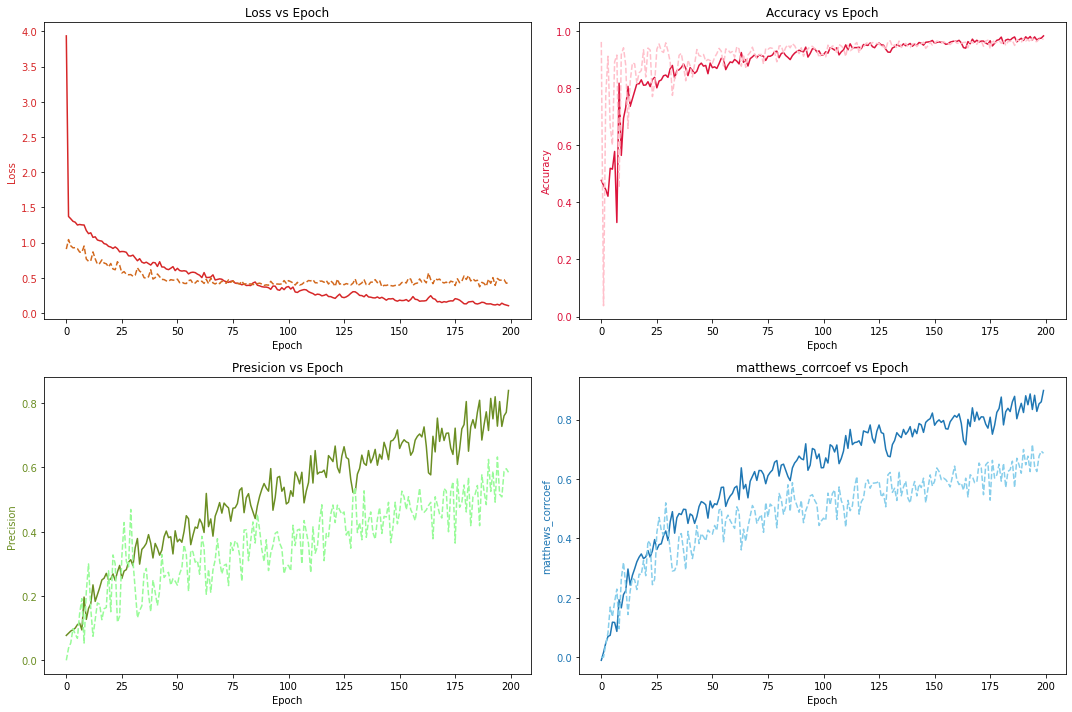

In [13]:
fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
t = range(EPOCHS)


# Loss
ax1[0, 0].set_title('Loss vs Epoch')
ax1[0, 0].set_xlabel('Epoch')
ax1[0, 0].set_ylabel('Loss', color='tab:red')
ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
ax1[0, 0].plot(t, train_total_loss, color='tab:red')
ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

# Presicion
ax1[1, 0].set_title('Presicion vs Epoch')
ax1[1, 0].set_xlabel('Epoch')
ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

# matthews_corrcoef
ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
ax1[1, 1].set_xlabel('Epoch')
ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

# Accuracy
ax1[0, 1].set_title('Accuracy vs Epoch')
ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
ax1[0, 1].set_xlabel('Epoch')
ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

ax1[0, 1].plot(t, train_accuracy, color='crimson')
ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

fig.tight_layout() 
plt.show()

## Optuna hyperparameter search

In [6]:
!pip install optuna
# !pip install rdkit-pypi

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 43.2 MB/s 
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 149 kB 51.3 MB/s 
     |████████████████████████████████| 112 kB 52.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=50b802074d1d0311a66903d01486021522d05964fac2d842ab547d04c0c6a4e0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [7]:
import torch
import optuna
import pandas as pd
from optuna.trial import TrialState

[I 2021-11-24 02:22:21,685] A new study created in memory with name: no-name-bd1ab339-2716-4a40-b351-d5d44a91049e


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.5744 | precision_score 0.0747 | matthews_corrcoef -0.0359 | accuracy 0.2729
loss 1.1500 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.4534 | precision_score 0.0776 | matthews_corrcoef -0.0107 | accuracy 0.4409
loss 1.0148 | precision_score 0.0394 | matthews_corrcoef 0.0399 | accuracy 0.0768

Epoch 40
loss 1.3777 | precision_score 0.0892 | matthews_corrcoef 0.0322 | accuracy 0.5210
loss 0.9562 | precision_score 0.0571 | matthews_corrcoef 0.0472 | accuracy 0.8035

Epoch 60
loss 1.3570 | precision_score 0.0866 | matthews_corrcoef 0.0246 | accuracy 0.4952
loss 0.9593 | precision_score 0.0679 | matthews_corrcoef 0.1108 | accuracy 0.6755

Epoch 80
loss 1.3231 | precision_score 0.0986 | matthews_corrcoef 0.0651 | accuracy 0.5355
loss 0.9449 | precision_score 0.0717 | matthews_corrcoef 0.1198 | accura

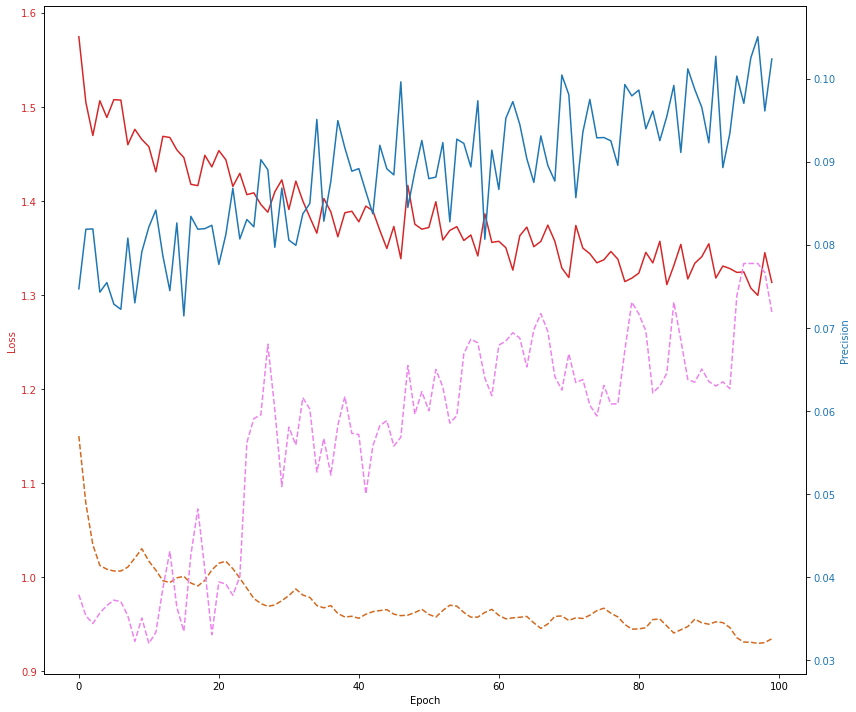

[I 2021-11-24 02:28:28,759] Trial 0 finished with value: 0.057280837564999076 and parameters: {'lr': 1.8459707434461382e-06, 'weight_decay': 0.0027175431598270836, 'num_layers': 3, 'hidden_channels': 420}. Best is trial 0 with value: 0.057280837564999076.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4458 | precision_score 0.0838 | matthews_corrcoef 0.0121 | accuracy 0.5436
loss 1.0709 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0085 | precision_score 0.2342 | matthews_corrcoef 0.2989 | accuracy 0.8043
loss 0.8677 | precision_score 0.0872 | matthews_corrcoef 0.1714 | accuracy 0.7103

Epoch 40
loss 0.7909 | precision_score 0.3186 | matthews_corrcoef 0.4240 | accuracy 0.8512
loss 0.8324 | precision_score 0.0988 | matthews_corrcoef 0.2354 | accuracy 0.6796

Epoch 60
loss 0.7011 | precision_score 0.3372 | matthews_corrcoef 0.4579 | accuracy 0.8581
loss 0.4605 | precision_score 0.2913 | matthews_corrcoef 0.4557 | accuracy 0.9181

Epoch 80
loss 0.6280 | precision_score 0.3484 | matthews_corrcoef 0.4870 | accuracy 0.8606
loss 0.4618 | precision_score 0.2478 | matthews_corrcoef 0.3977 | accuracy

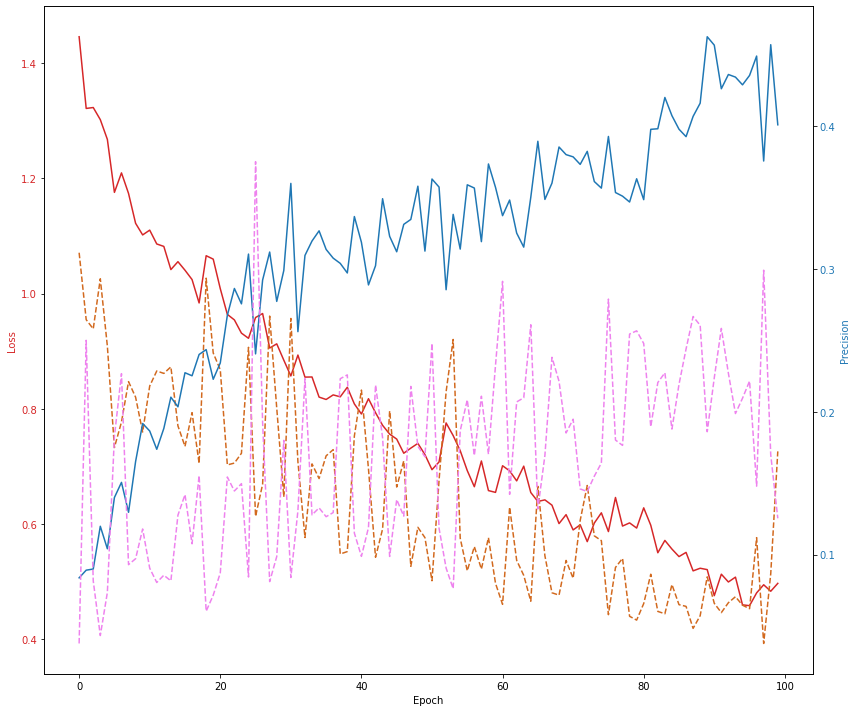

[I 2021-11-24 02:31:54,297] Trial 1 finished with value: 0.16867568939624616 and parameters: {'lr': 0.0007849377982937009, 'weight_decay': 0.0002790872368937068, 'num_layers': 4, 'hidden_channels': 220}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3802 | precision_score 0.0801 | matthews_corrcoef -0.0004 | accuracy 0.4529
loss 0.9893 | precision_score 0.0476 | matthews_corrcoef 0.0484 | accuracy 0.5343

Epoch 20
loss 1.2868 | precision_score 0.1082 | matthews_corrcoef 0.0912 | accuracy 0.5761
loss 0.9349 | precision_score 0.0710 | matthews_corrcoef 0.1182 | accuracy 0.6899

Epoch 40
loss 1.1998 | precision_score 0.1459 | matthews_corrcoef 0.1845 | accuracy 0.6597
loss 0.8516 | precision_score 0.0893 | matthews_corrcoef 0.1707 | accuracy 0.7267

Epoch 60
loss 1.1351 | precision_score 0.1679 | matthews_corrcoef 0.2168 | accuracy 0.7135
loss 0.8044 | precision_score 0.1053 | matthews_corrcoef 0.1948 | accuracy 0.7779

Epoch 80
loss 1.1169 | precision_score 0.1872 | matthews_corrcoef 0.2465 | accuracy 0.7440
loss 0.8026 | precision_score 0.1043 | matthews_corrcoef 0.1932 | accurac

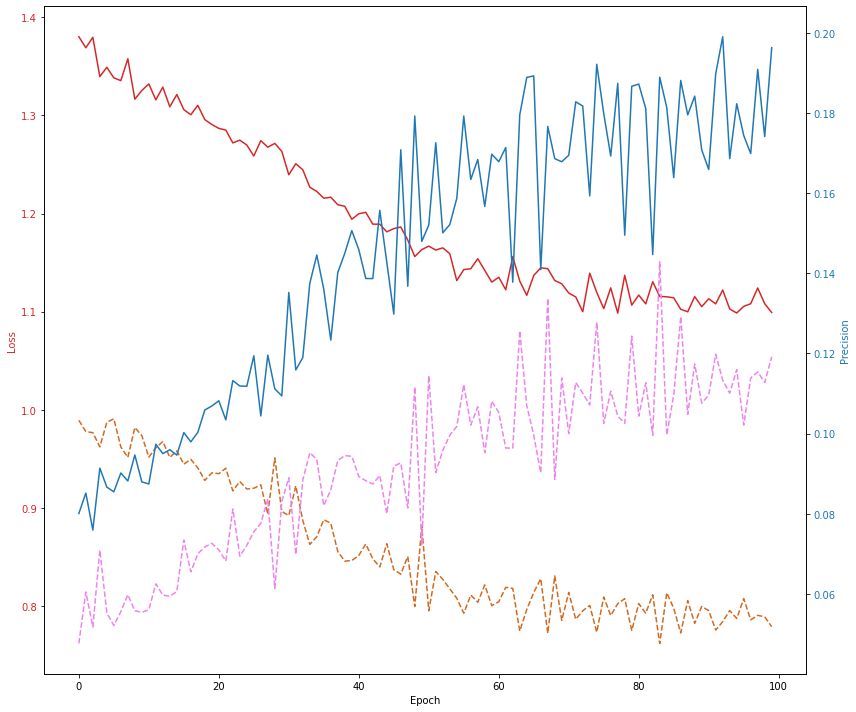

[I 2021-11-24 02:35:21,197] Trial 2 finished with value: 0.09174018176222037 and parameters: {'lr': 2.6973579592920693e-05, 'weight_decay': 0.003647328245361531, 'num_layers': 4, 'hidden_channels': 220}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3552 | precision_score 0.0803 | matthews_corrcoef 0.0007 | accuracy 0.5114
loss 1.0181 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.3215 | precision_score 0.0944 | matthews_corrcoef 0.0548 | accuracy 0.4974
loss 0.9732 | precision_score 0.0625 | matthews_corrcoef 0.0968 | accuracy 0.6469

Epoch 40
loss 1.2952 | precision_score 0.1055 | matthews_corrcoef 0.0923 | accuracy 0.5301
loss 0.9402 | precision_score 0.0722 | matthews_corrcoef 0.1170 | accuracy 0.7073

Epoch 60
loss 1.2674 | precision_score 0.1120 | matthews_corrcoef 0.1163 | accuracy 0.5348
loss 0.9193 | precision_score 0.0712 | matthews_corrcoef 0.1308 | accuracy 0.6540

Epoch 80
loss 1.2233 | precision_score 0.1463 | matthews_corrcoef 0.1721 | accuracy 0.6845
loss 0.8305 | precision_score 0.1198 | matthews_corrcoef 0.2122 | accuracy

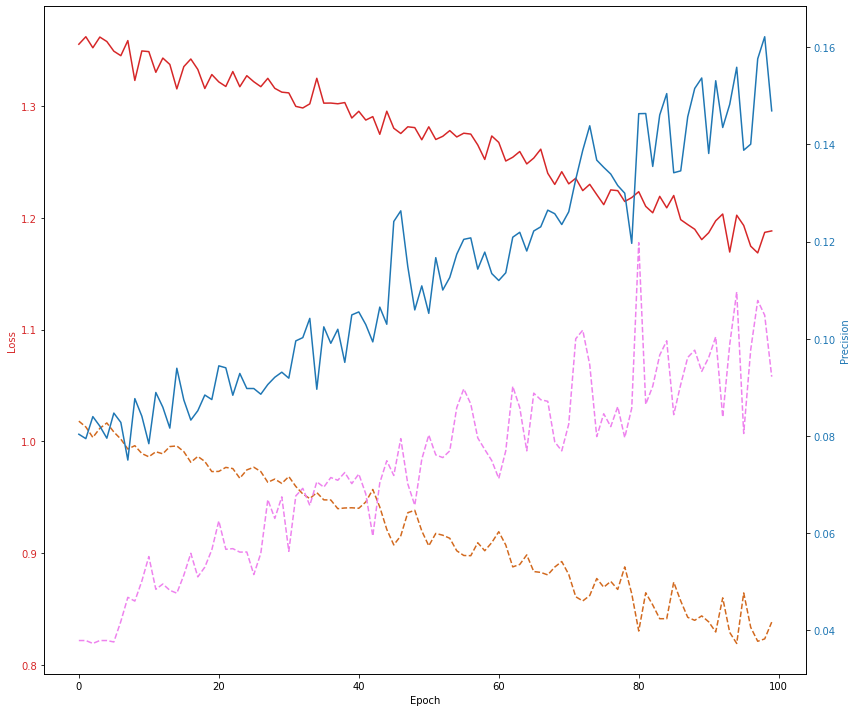

[I 2021-11-24 02:46:22,023] Trial 3 finished with value: 0.07337279989916123 and parameters: {'lr': 3.944426375130759e-06, 'weight_decay': 0.00042842849599118493, 'num_layers': 5, 'hidden_channels': 520}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 1.7122 | precision_score 0.0638 | matthews_corrcoef -0.0229 | accuracy 0.8090
loss 0.9162 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

Epoch 20
loss 1.2985 | precision_score 0.0993 | matthews_corrcoef 0.0745 | accuracy 0.4972
loss 0.9285 | precision_score 0.1525 | matthews_corrcoef 0.2227 | accuracy 0.8782

Epoch 40
loss 1.1628 | precision_score 0.1831 | matthews_corrcoef 0.2187 | accuracy 0.7615
loss 0.8023 | precision_score 0.1575 | matthews_corrcoef 0.2628 | accuracy 0.8598

Epoch 60
loss 1.0864 | precision_score 0.1879 | matthews_corrcoef 0.2402 | accuracy 0.7524
loss 0.7641 | precision_score 0.1402 | matthews_corrcoef 0.2409 | accuracy 0.8414

Epoch 80
loss 1.0626 | precision_score 0.2497 | matthews_corrcoef 0.3063 | accuracy 0.8227
loss 0.7707 | precision_score 0.1278 | matthews_corrcoef 0.2238 | accuracy 0.8250



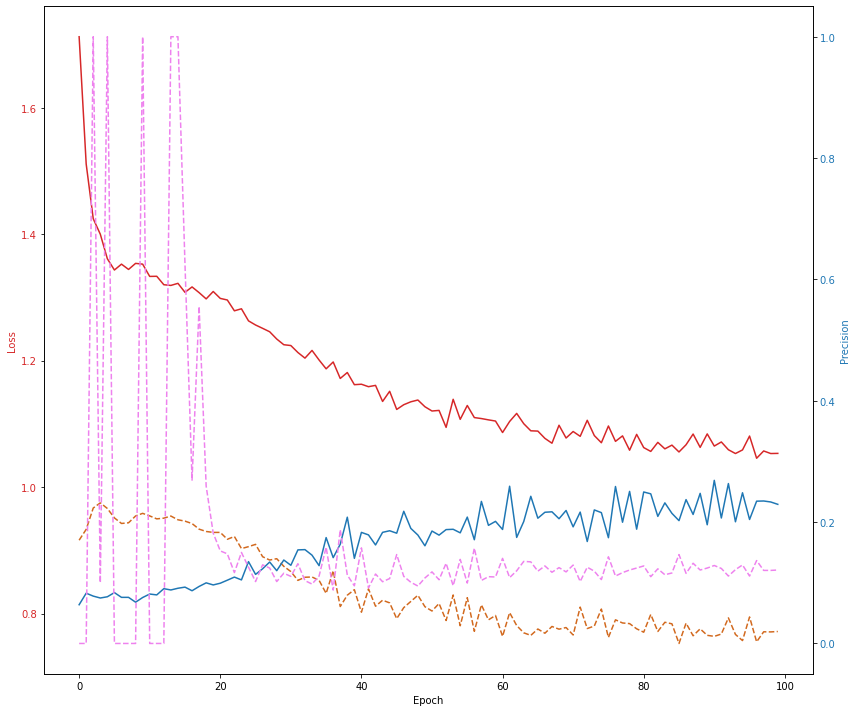

[I 2021-11-24 02:47:59,709] Trial 4 finished with value: 0.16653247708729194 and parameters: {'lr': 0.00045175907958522517, 'weight_decay': 0.0015666400960231862, 'num_layers': 3, 'hidden_channels': 20}. Best is trial 1 with value: 0.16867568939624616.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 5.4857 | precision_score 0.0893 | matthews_corrcoef 0.0367 | accuracy 0.4743
loss 1.1498 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 0.9596 | precision_score 0.2340 | matthews_corrcoef 0.3161 | accuracy 0.7935
loss 0.6069 | precision_score 0.3467 | matthews_corrcoef 0.4665 | accuracy 0.9386

Epoch 40
loss 0.8347 | precision_score 0.2900 | matthews_corrcoef 0.3896 | accuracy 0.8348
loss 0.6192 | precision_score 0.1842 | matthews_corrcoef 0.3291 | accuracy 0.8639

Epoch 60
loss 0.8319 | precision_score 0.2869 | matthews_corrcoef 0.3905 | accuracy 0.8311
loss 0.5213 | precision_score 0.3485 | matthews_corrcoef 0.4380 | accuracy 0.9417

Epoch 80
loss 0.7761 | precision_score 0.3219 | matthews_corrcoef 0.4357 | accuracy 0.8510
loss 0.6306 | precision_score 0.2301 | matthews_corrcoef 0.3642 | accuracy

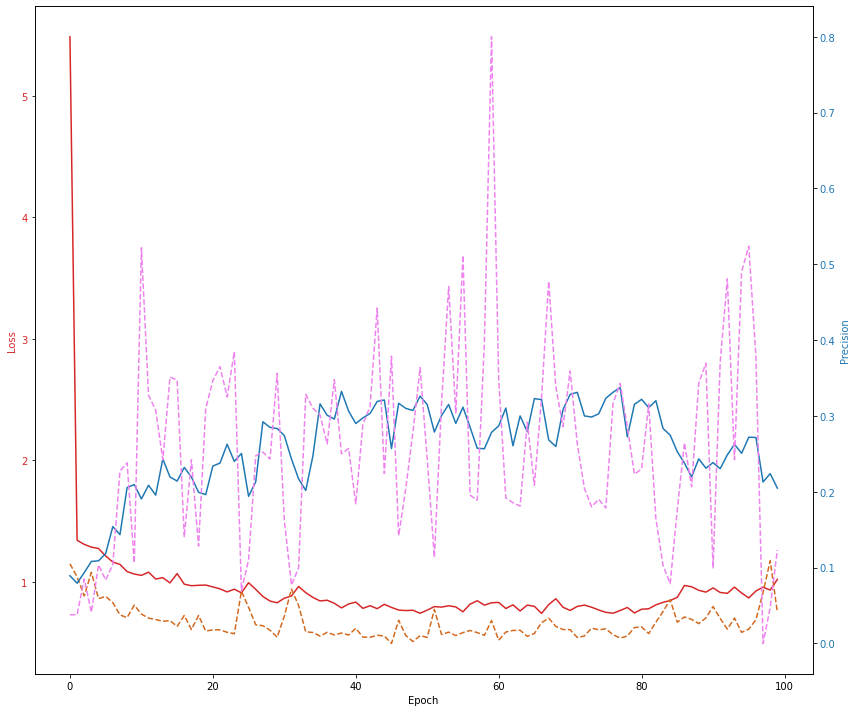

[I 2021-11-24 02:54:40,469] Trial 5 finished with value: 0.2582699813600665 and parameters: {'lr': 0.003443360276897034, 'weight_decay': 3.437657176543441e-06, 'num_layers': 4, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3564 | precision_score 0.0851 | matthews_corrcoef 0.0211 | accuracy 0.4426
loss 1.0117 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 20
loss 1.2189 | precision_score 0.1510 | matthews_corrcoef 0.1800 | accuracy 0.6949
loss 0.8996 | precision_score 0.0750 | matthews_corrcoef 0.1486 | accuracy 0.6489

Epoch 40
loss 1.1313 | precision_score 0.2057 | matthews_corrcoef 0.2421 | accuracy 0.7932
loss 0.8561 | precision_score 0.0808 | matthews_corrcoef 0.1487 | accuracy 0.7073

Epoch 60
loss 1.1149 | precision_score 0.1869 | matthews_corrcoef 0.2413 | accuracy 0.7485
loss 0.8311 | precision_score 0.0888 | matthews_corrcoef 0.1603 | accuracy 0.7441

Epoch 80
loss 1.0780 | precision_score 0.2195 | matthews_corrcoef 0.2802 | accuracy 0.7910
loss 0.8040 | precision_score 0.1031 | matthews_corrcoef 0.1860 | accuracy 0.7810



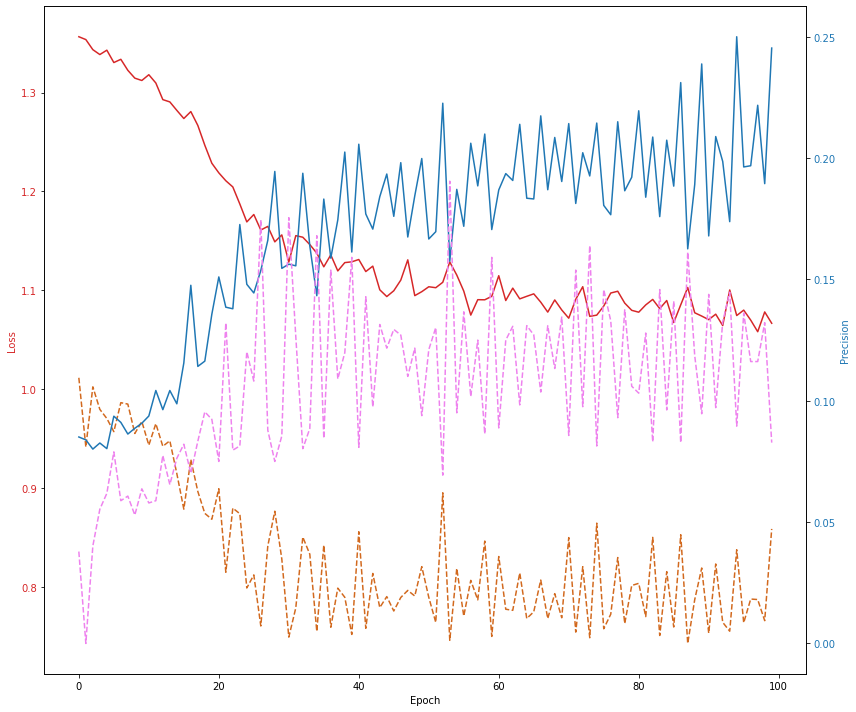

[I 2021-11-24 03:02:47,430] Trial 6 finished with value: 0.10651753016701321 and parameters: {'lr': 4.1469508685551376e-05, 'weight_decay': 0.006752815218270218, 'num_layers': 5, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 1.4419 | precision_score 0.0806 | matthews_corrcoef 0.0010 | accuracy 0.6356
loss 0.9656 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 1.3855 | precision_score 0.0823 | matthews_corrcoef 0.0080 | accuracy 0.4903
loss 1.0239 | precision_score 0.0353 | matthews_corrcoef -0.0637 | accuracy 0.0727

Epoch 40
loss 1.3554 | precision_score 0.0843 | matthews_corrcoef 0.0162 | accuracy 0.4785
loss 1.0270 | precision_score 0.0370 | matthews_corrcoef -0.0192 | accuracy 0.0901

Epoch 60
loss 1.3494 | precision_score 0.0847 | matthews_corrcoef 0.0178 | accuracy 0.4760
loss 1.0166 | precision_score 0.0401 | matthews_corrcoef 0.0270 | accuracy 0.1873

Epoch 80
loss 1.3429 | precision_score 0.0918 | matthews_corrcoef 0.0457 | accuracy 0.4871
loss 1.0072 | precision_score 0.0423 | matthews_corrcoef 0.0379 | accuracy 0.2979



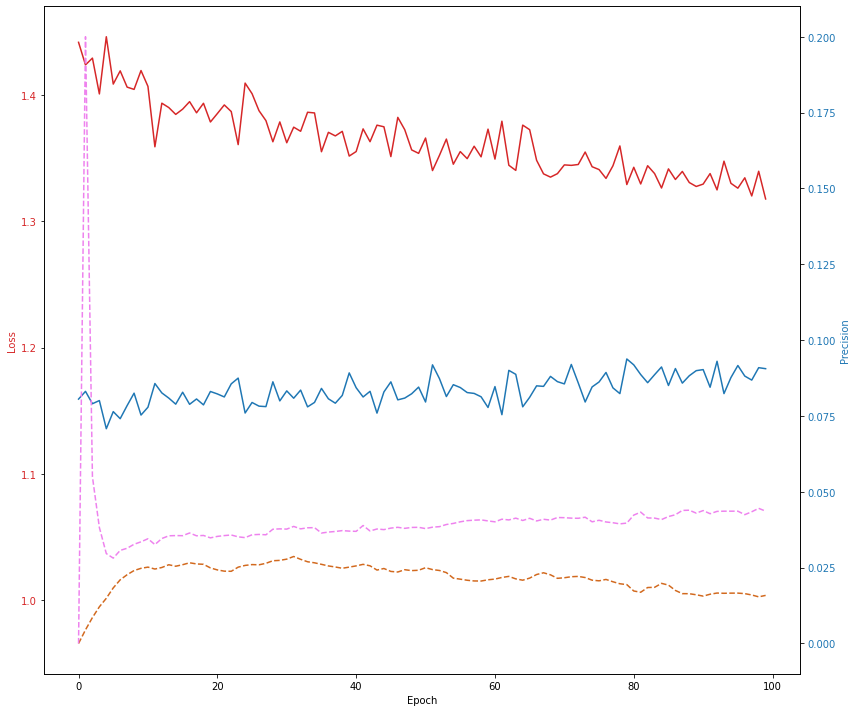

[I 2021-11-24 03:05:05,089] Trial 7 finished with value: 0.040117626734398414 and parameters: {'lr': 5.023848640222555e-06, 'weight_decay': 0.000698778113028354, 'num_layers': 4, 'hidden_channels': 120}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4463 | precision_score 0.0813 | matthews_corrcoef 0.0044 | accuracy 0.4765
loss 0.9903 | precision_score 0.0503 | matthews_corrcoef 0.0817 | accuracy 0.4135

Epoch 20
loss 1.1895 | precision_score 0.1462 | matthews_corrcoef 0.1870 | accuracy 0.6567
loss 0.8354 | precision_score 0.0945 | matthews_corrcoef 0.1758 | accuracy 0.7513

Epoch 40
loss 1.1426 | precision_score 0.1460 | matthews_corrcoef 0.1914 | accuracy 0.6479
loss 0.8542 | precision_score 0.0755 | matthews_corrcoef 0.1412 | accuracy 0.6745

Epoch 60
loss 1.0744 | precision_score 0.1614 | matthews_corrcoef 0.2331 | accuracy 0.6639
loss 0.8120 | precision_score 0.0909 | matthews_corrcoef 0.1691 | accuracy 0.7410

Epoch 80
loss 1.0706 | precision_score 0.1857 | matthews_corrcoef 0.2460 | accuracy 0.7401
loss 0.8095 | precision_score 0.0879 | matthews_corrcoef 0.1632 | accuracy

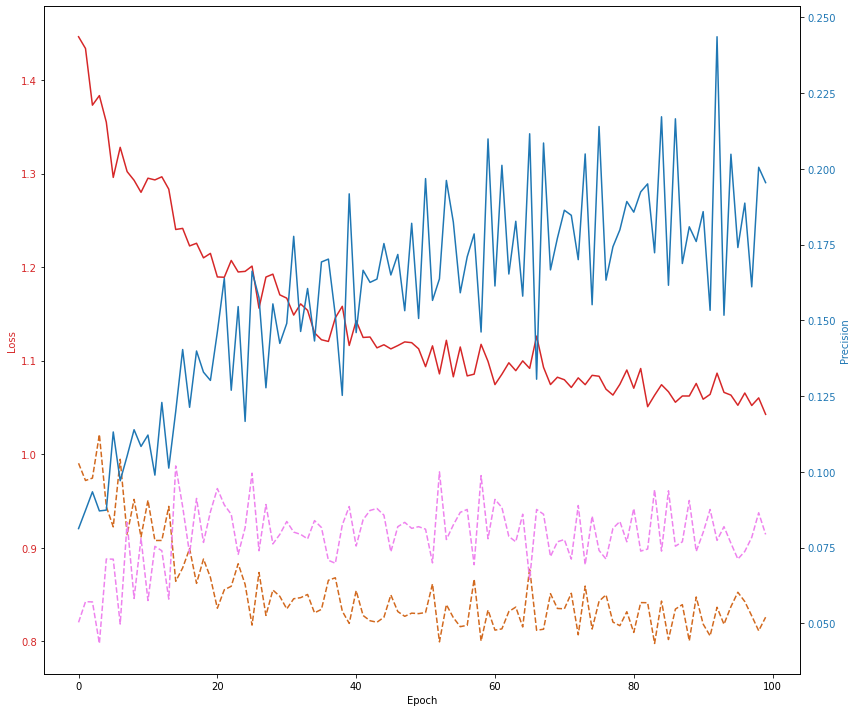

[I 2021-11-24 03:12:33,272] Trial 8 finished with value: 0.07892591675642202 and parameters: {'lr': 1.5323207709942157e-05, 'weight_decay': 4.137035397696976e-05, 'num_layers': 3, 'hidden_channels': 520}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 5.0044 | precision_score 0.0797 | matthews_corrcoef -0.0015 | accuracy 0.5232
loss 0.9176 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 1.0069 | precision_score 0.2005 | matthews_corrcoef 0.2837 | accuracy 0.7458
loss 0.7075 | precision_score 0.1290 | matthews_corrcoef 0.2316 | accuracy 0.8209

Epoch 40
loss 0.7437 | precision_score 0.3270 | matthews_corrcoef 0.4471 | accuracy 0.8525
loss 0.5985 | precision_score 0.1531 | matthews_corrcoef 0.3023 | accuracy 0.8229

Epoch 60
loss 0.6170 | precision_score 0.3762 | matthews_corrcoef 0.5103 | accuracy 0.8753
loss 0.4455 | precision_score 0.2541 | matthews_corrcoef 0.4279 | accuracy 0.9007

Epoch 80
loss 0.4372 | precision_score 0.4799 | matthews_corrcoef 0.6249 | accuracy 0.9137
loss 0.4062 | precision_score 0.3107 | matthews_corrcoef 0.4906 | accuracy 0.9222



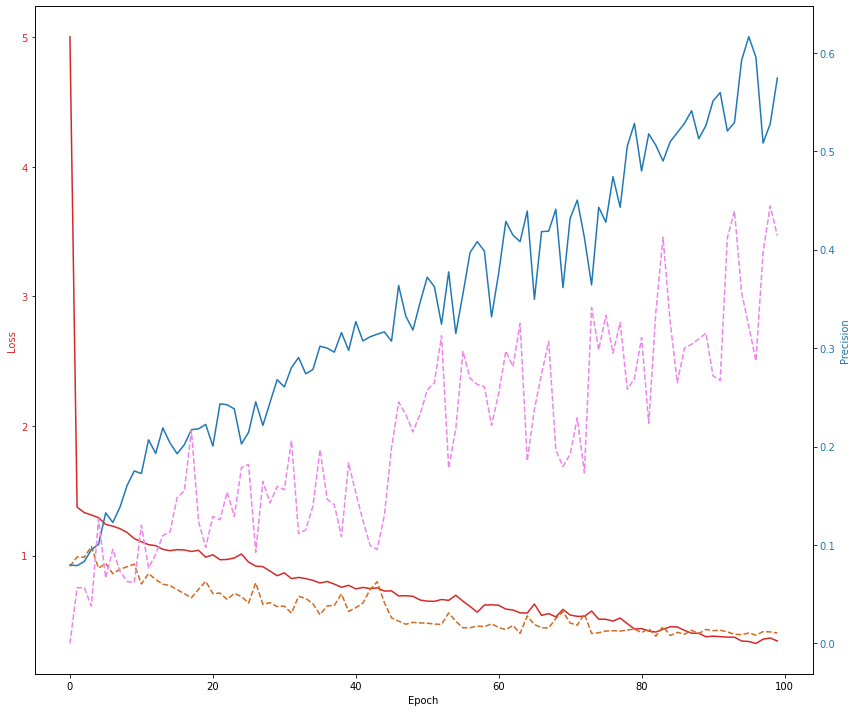

[I 2021-11-24 03:16:48,112] Trial 9 finished with value: 0.21089850679388622 and parameters: {'lr': 0.0015294022249668856, 'weight_decay': 6.502161136338155e-05, 'num_layers': 2, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 8.5886 | precision_score 0.0775 | matthews_corrcoef -0.0098 | accuracy 0.4937
loss 0.9878 | precision_score 0.0470 | matthews_corrcoef 0.0569 | accuracy 0.4289

Epoch 20
loss 1.0314 | precision_score 0.1870 | matthews_corrcoef 0.2518 | accuracy 0.7379
loss 0.9138 | precision_score 0.0671 | matthews_corrcoef 0.1407 | accuracy 0.5660

Epoch 40
loss 1.0197 | precision_score 0.1994 | matthews_corrcoef 0.2638 | accuracy 0.7605
loss 0.7118 | precision_score 0.1337 | matthews_corrcoef 0.2562 | accuracy 0.8106

Epoch 60
loss 0.9406 | precision_score 0.2211 | matthews_corrcoef 0.3105 | accuracy 0.7728
loss 0.6193 | precision_score 0.2222 | matthews_corrcoef 0.3405 | accuracy 0.9007

Epoch 80
loss 1.1210 | precision_score 0.1598 | matthews_corrcoef 0.2040 | accuracy 0.6978
loss 0.7492 | precision_score 0.1852 | matthews_corrcoef 0.2721 | accurac

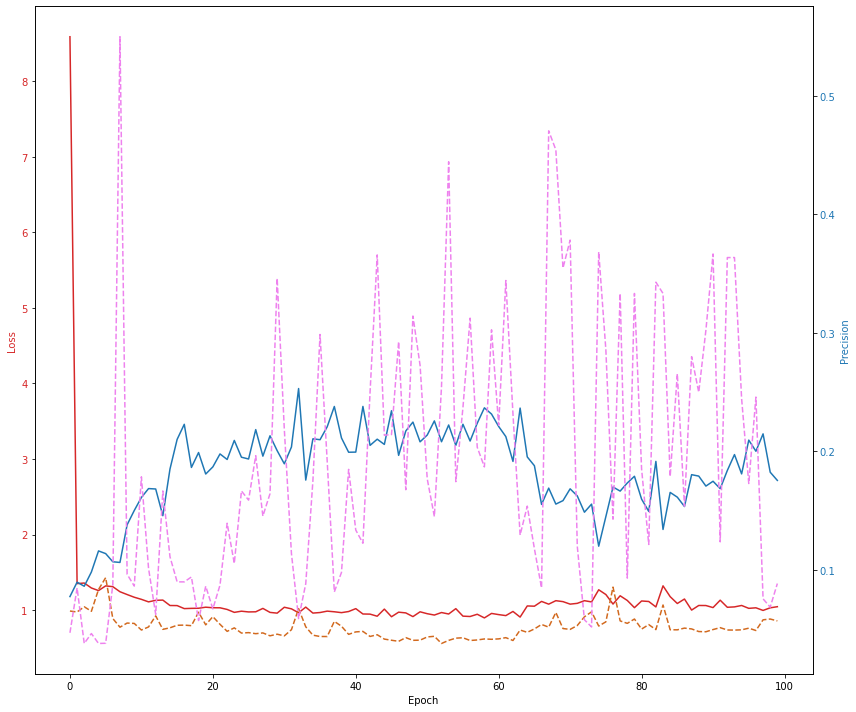

[I 2021-11-24 03:19:51,412] Trial 10 finished with value: 0.19279376788328026 and parameters: {'lr': 0.009019532552299203, 'weight_decay': 1.7518611326056967e-06, 'num_layers': 2, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 11.4287 | precision_score 0.0774 | matthews_corrcoef -0.0102 | accuracy 0.4905
loss 0.9760 | precision_score 0.0405 | matthews_corrcoef 0.0096 | accuracy 0.6602

Epoch 20
loss 1.0872 | precision_score 0.1579 | matthews_corrcoef 0.2176 | accuracy 0.6695
loss 0.7235 | precision_score 0.2400 | matthews_corrcoef 0.3053 | accuracy 0.9222

Epoch 40
loss 1.0430 | precision_score 0.1931 | matthews_corrcoef 0.2660 | accuracy 0.7416
loss 0.6869 | precision_score 0.2174 | matthews_corrcoef 0.3032 | accuracy 0.9089

Epoch 60
loss 1.0281 | precision_score 0.1741 | matthews_corrcoef 0.2369 | accuracy 0.7118
loss 0.7007 | precision_score 0.1979 | matthews_corrcoef 0.2768 | accuracy 0.9028

Epoch 80
loss 0.9713 | precision_score 0.2256 | matthews_corrcoef 0.3072 | accuracy 0.7841
loss 0.7688 | precision_score 0.1086 | matthews_corrcoef 0.2273 | accura

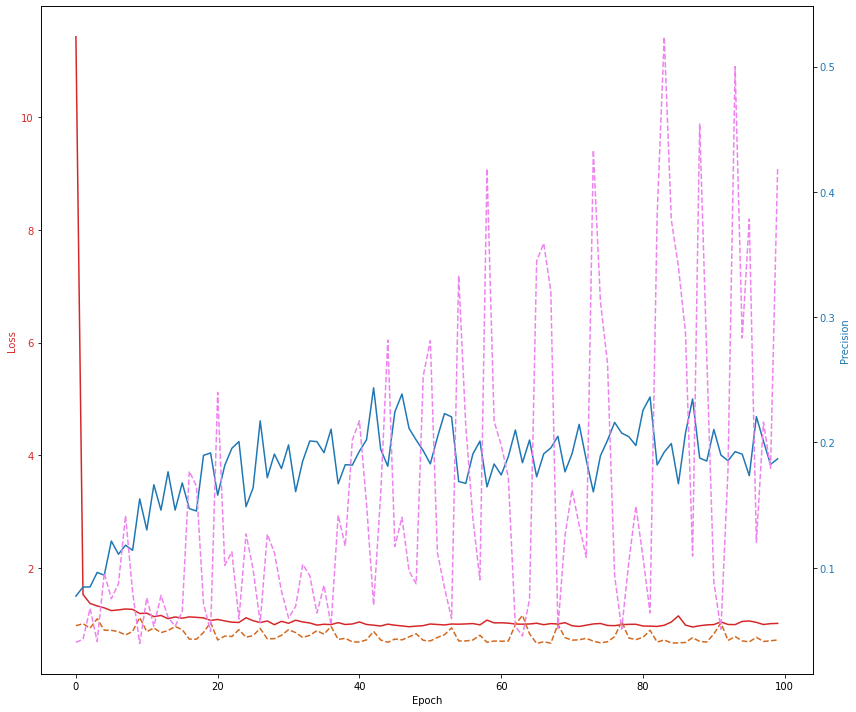

[I 2021-11-24 03:24:04,175] Trial 11 finished with value: 0.1608229595608687 and parameters: {'lr': 0.008659187844254696, 'weight_decay': 1.5728222253155644e-05, 'num_layers': 2, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.6156 | precision_score 0.0764 | matthews_corrcoef -0.0165 | accuracy 0.4209
loss 0.9082 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9387 | precision_score 0.2489 | matthews_corrcoef 0.3370 | accuracy 0.8058
loss 0.7713 | precision_score 0.1085 | matthews_corrcoef 0.2217 | accuracy 0.7554

Epoch 40
loss 0.7225 | precision_score 0.3761 | matthews_corrcoef 0.4875 | accuracy 0.8785
loss 0.6092 | precision_score 0.1475 | matthews_corrcoef 0.3068 | accuracy 0.8055

Epoch 60
loss 0.5724 | precision_score 0.4367 | matthews_corrcoef 0.5632 | accuracy 0.9002
loss 0.4291 | precision_score 0.2743 | matthews_corrcoef 0.4480 | accuracy 0.9099

Epoch 80
loss 0.4305 | precision_score 0.4771 | matthews_corrcoef 0.6276 | accuracy 0.9127
loss 0.4031 | precision_score 0.3506 | matthews_corrcoef 0.4793 | accuracy 0.9386



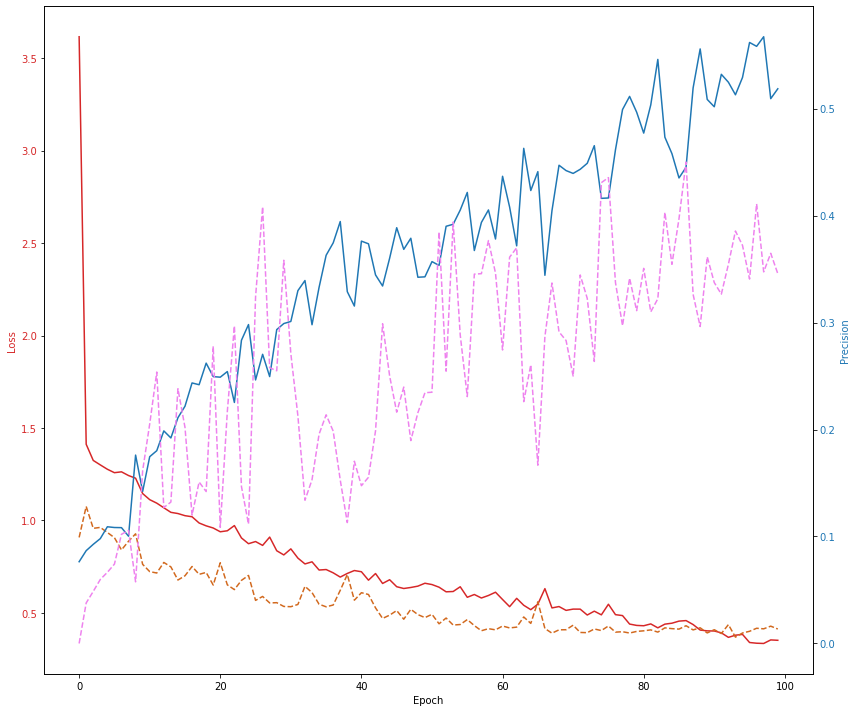

[I 2021-11-24 03:27:08,580] Trial 12 finished with value: 0.2555535528023482 and parameters: {'lr': 0.001164884005365969, 'weight_decay': 3.7540522058417304e-06, 'num_layers': 2, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 3.2784 | precision_score 0.0841 | matthews_corrcoef 0.0138 | accuracy 0.5208
loss 1.0615 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0081 | precision_score 0.2535 | matthews_corrcoef 0.3141 | accuracy 0.8237
loss 0.6774 | precision_score 0.2593 | matthews_corrcoef 0.3487 | accuracy 0.9222

Epoch 40
loss 0.7751 | precision_score 0.3356 | matthews_corrcoef 0.4400 | accuracy 0.8608
loss 0.7949 | precision_score 0.0920 | matthews_corrcoef 0.2057 | accuracy 0.6807

Epoch 60
loss 0.6597 | precision_score 0.3739 | matthews_corrcoef 0.4959 | accuracy 0.8761
loss 0.5073 | precision_score 0.2500 | matthews_corrcoef 0.4079 | accuracy 0.9028

Epoch 80
loss 0.6686 | precision_score 0.3424 | matthews_corrcoef 0.4812 | accuracy 0.8571
loss 0.4356 | precision_score 0.3111 | matthews_corrcoef 0.4560 | accuracy

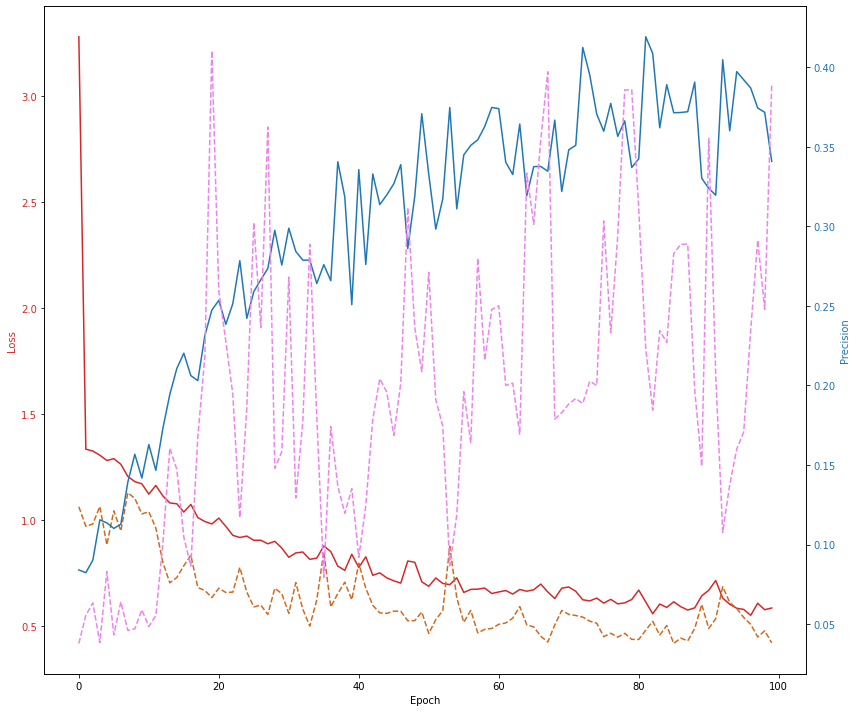

[I 2021-11-24 03:31:46,435] Trial 13 finished with value: 0.19614748548860353 and parameters: {'lr': 0.002938611287145778, 'weight_decay': 1.366538292947111e-06, 'num_layers': 4, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4573 | precision_score 0.0884 | matthews_corrcoef 0.0354 | accuracy 0.4485
loss 0.9571 | precision_score 0.0529 | matthews_corrcoef 0.0409 | accuracy 0.7718

Epoch 20
loss 1.0697 | precision_score 0.1914 | matthews_corrcoef 0.2523 | accuracy 0.7502
loss 0.7706 | precision_score 0.1070 | matthews_corrcoef 0.1923 | accuracy 0.7892

Epoch 40
loss 0.9145 | precision_score 0.2322 | matthews_corrcoef 0.3287 | accuracy 0.7826
loss 0.9385 | precision_score 0.0651 | matthews_corrcoef 0.1481 | accuracy 0.5107

Epoch 60
loss 0.8114 | precision_score 0.2845 | matthews_corrcoef 0.4051 | accuracy 0.8230
loss 0.5991 | precision_score 0.1637 | matthews_corrcoef 0.3037 | accuracy 0.8444

Epoch 80
loss 0.7409 | precision_score 0.3342 | matthews_corrcoef 0.4507 | accuracy 0.8574
loss 0.5560 | precision_score 0.1703 | matthews_corrcoef 0.3320 | accuracy

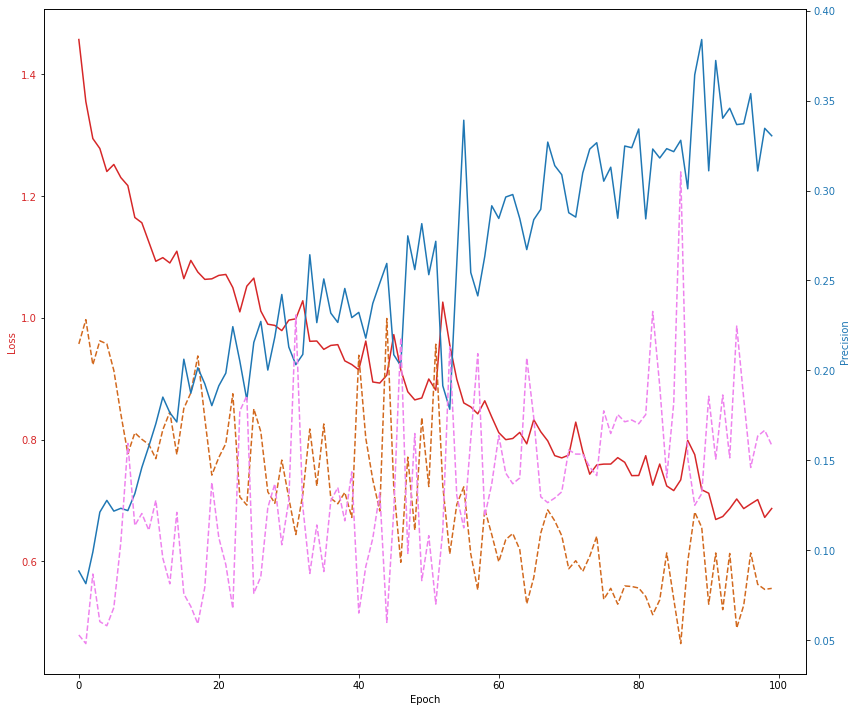

[I 2021-11-24 03:35:39,924] Trial 14 finished with value: 0.1341448470939642 and parameters: {'lr': 0.0002064622156829893, 'weight_decay': 7.580279465543369e-06, 'num_layers': 3, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3660 | precision_score 0.0788 | matthews_corrcoef -0.0064 | accuracy 0.3993
loss 1.0068 | precision_score 0.0393 | matthews_corrcoef 0.0290 | accuracy 0.0983

Epoch 20
loss 1.1019 | precision_score 0.2069 | matthews_corrcoef 0.2649 | accuracy 0.7770
loss 0.8415 | precision_score 0.0875 | matthews_corrcoef 0.1576 | accuracy 0.7400

Epoch 40
loss 1.0461 | precision_score 0.2048 | matthews_corrcoef 0.2759 | accuracy 0.7632
loss 0.7469 | precision_score 0.1469 | matthews_corrcoef 0.2364 | accuracy 0.8588

Epoch 60
loss 0.9781 | precision_score 0.2416 | matthews_corrcoef 0.3212 | accuracy 0.8030
loss 0.6854 | precision_score 0.2233 | matthews_corrcoef 0.3335 | accuracy 0.9038

Epoch 80
loss 0.9301 | precision_score 0.2769 | matthews_corrcoef 0.3530 | accuracy 0.8343
loss 0.6533 | precision_score 0.1852 | matthews_corrcoef 0.3090 | accurac

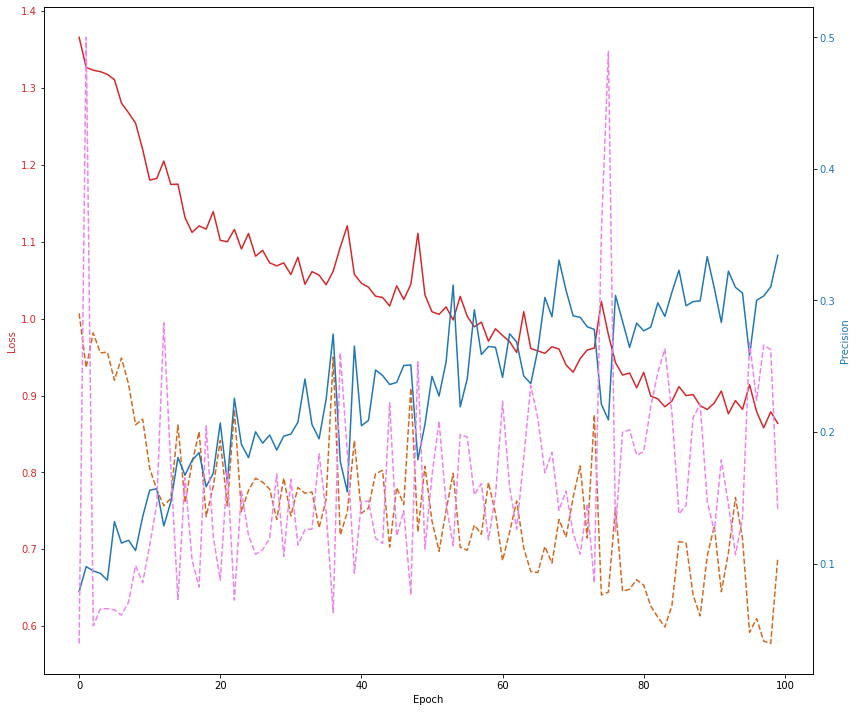

[I 2021-11-24 03:39:39,419] Trial 15 finished with value: 0.15937317604032988 and parameters: {'lr': 0.0001367543538115252, 'weight_decay': 6.634249942772138e-06, 'num_layers': 5, 'hidden_channels': 220}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 10.6322 | precision_score 0.0733 | matthews_corrcoef -0.0237 | accuracy 0.5218
loss 1.1359 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0427 | precision_score 0.2017 | matthews_corrcoef 0.2820 | accuracy 0.7504
loss 0.6495 | precision_score 0.2923 | matthews_corrcoef 0.3559 | accuracy 0.9345

Epoch 40
loss 0.9256 | precision_score 0.2147 | matthews_corrcoef 0.3076 | accuracy 0.7610
loss 0.5647 | precision_score 0.3333 | matthews_corrcoef 0.4463 | accuracy 0.9365

Epoch 60
loss 0.8680 | precision_score 0.2574 | matthews_corrcoef 0.3608 | accuracy 0.8062
loss 0.7716 | precision_score 0.1038 | matthews_corrcoef 0.2398 | accuracy 0.7042

Epoch 80
loss 0.7802 | precision_score 0.2807 | matthews_corrcoef 0.3831 | accuracy 0.8269
loss 0.4878 | precision_score 0.3034 | matthews_corrcoef 0.4403 | accura

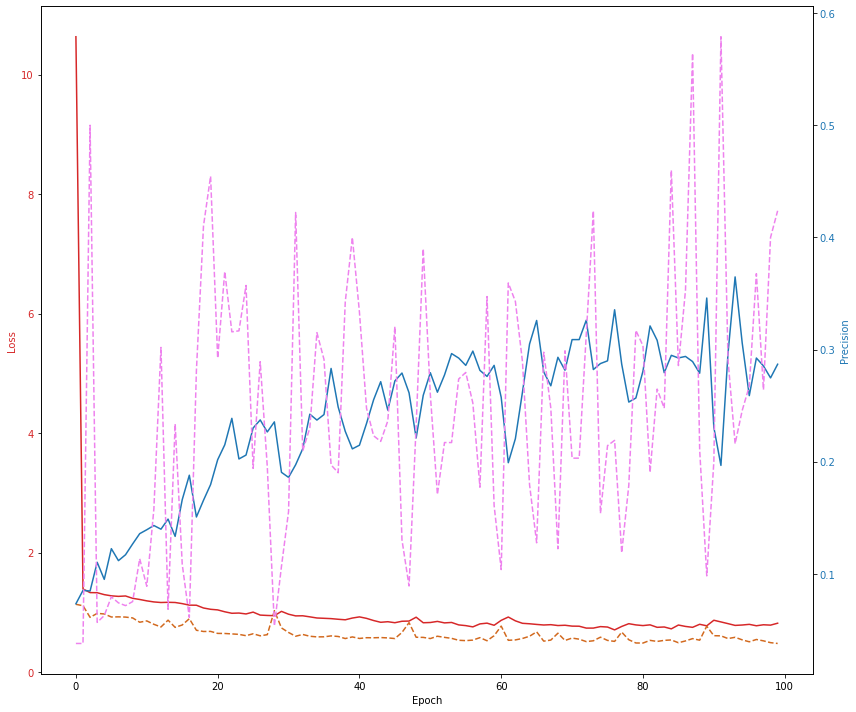

[I 2021-11-24 03:45:15,669] Trial 16 finished with value: 0.24240943334545212 and parameters: {'lr': 0.0028151840375554185, 'weight_decay': 3.2540157935713793e-06, 'num_layers': 2, 'hidden_channels': 520}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.4521 | precision_score 0.0854 | matthews_corrcoef 0.0201 | accuracy 0.4927
loss 1.0448 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 1.0218 | precision_score 0.2482 | matthews_corrcoef 0.3172 | accuracy 0.8151
loss 0.7961 | precision_score 0.1096 | matthews_corrcoef 0.2020 | accuracy 0.7871

Epoch 40
loss 0.8733 | precision_score 0.2873 | matthews_corrcoef 0.3767 | accuracy 0.8365
loss 0.6585 | precision_score 0.1753 | matthews_corrcoef 0.3115 | accuracy 0.8598

Epoch 60
loss 0.7625 | precision_score 0.2963 | matthews_corrcoef 0.4103 | accuracy 0.8343
loss 0.5974 | precision_score 0.1542 | matthews_corrcoef 0.3102 | accuracy 0.8199

Epoch 80
loss 0.6374 | precision_score 0.3701 | matthews_corrcoef 0.5049 | accuracy 0.8724
loss 0.5146 | precision_score 0.1958 | matthews_corrcoef 0.3426 | accuracy

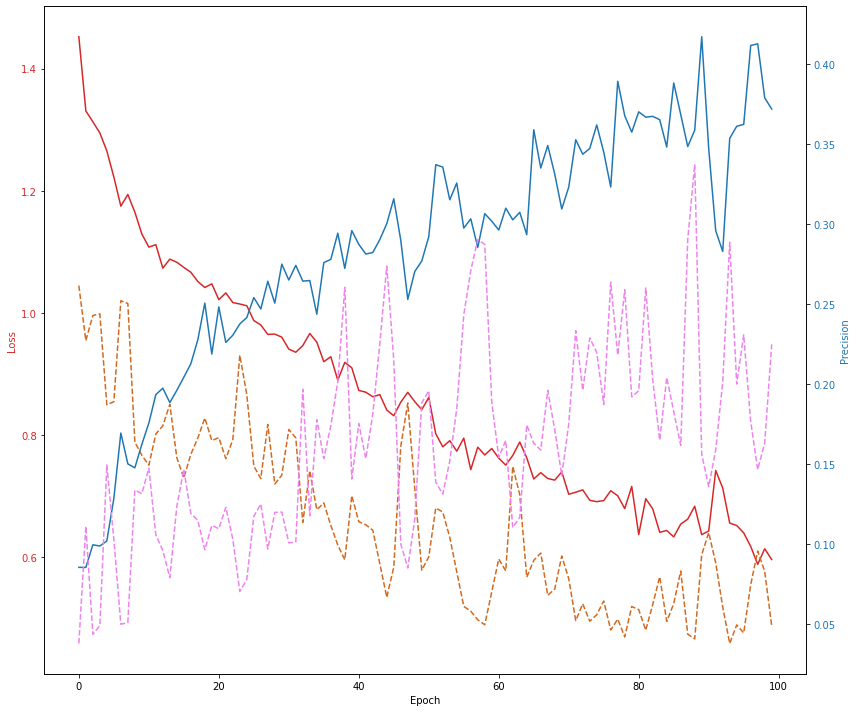

[I 2021-11-24 03:47:17,054] Trial 17 finished with value: 0.16290036723905055 and parameters: {'lr': 0.0007270885889303905, 'weight_decay': 2.3094305137797604e-05, 'num_layers': 3, 'hidden_channels': 120}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 3.5920 | precision_score 0.0826 | matthews_corrcoef 0.0087 | accuracy 0.5225
loss 1.0533 | precision_score 0.0379 | matthews_corrcoef 0.0000 | accuracy 0.0379

Epoch 20
loss 0.9988 | precision_score 0.2534 | matthews_corrcoef 0.3160 | accuracy 0.8227
loss 0.6002 | precision_score 0.2759 | matthews_corrcoef 0.3898 | accuracy 0.9222

Epoch 40
loss 0.7669 | precision_score 0.3421 | matthews_corrcoef 0.4482 | accuracy 0.8638
loss 0.7696 | precision_score 0.1041 | matthews_corrcoef 0.2405 | accuracy 0.7052

Epoch 60
loss 0.6991 | precision_score 0.3736 | matthews_corrcoef 0.4944 | accuracy 0.8761
loss 0.4470 | precision_score 0.3086 | matthews_corrcoef 0.4265 | accuracy 0.9304

Epoch 80
loss 0.6061 | precision_score 0.3815 | matthews_corrcoef 0.5174 | accuracy 0.8776
loss 0.4363 | precision_score 0.2520 | matthews_corrcoef 0.4335 | accuracy

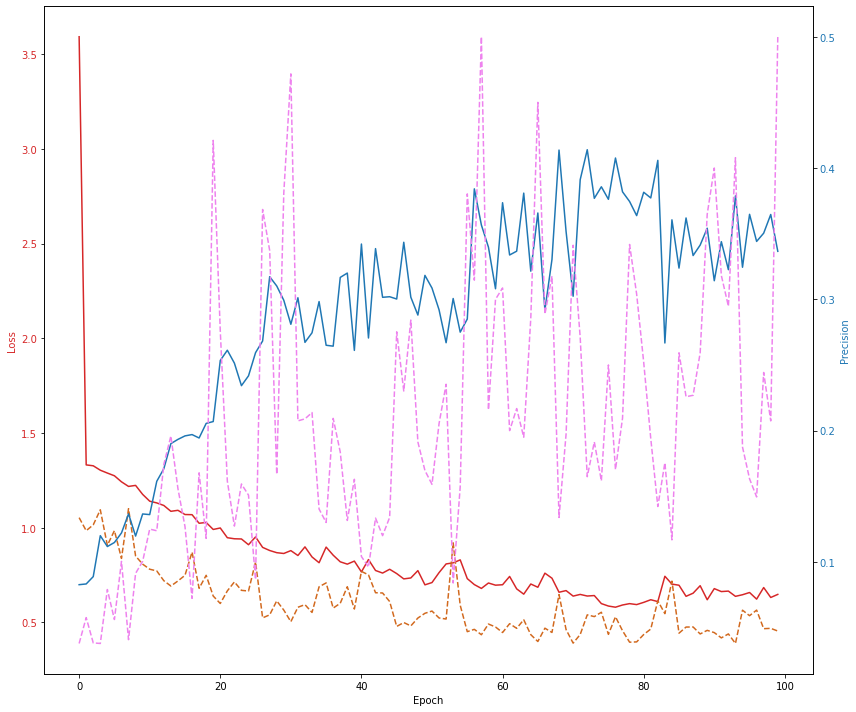

[I 2021-11-24 03:51:53,792] Trial 18 finished with value: 0.20972499433775585 and parameters: {'lr': 0.003249556735446683, 'weight_decay': 5.09072226421262e-06, 'num_layers': 4, 'hidden_channels': 320}. Best is trial 5 with value: 0.2582699813600665.


El número de valores en el dataset es de: 977 y tiene 37.0 positivos
El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
Epoch 0
loss 1.3469 | precision_score 0.0824 | matthews_corrcoef 0.0106 | accuracy 0.3964
loss 0.9396 | precision_score 0.0000 | matthews_corrcoef -0.0064 | accuracy 0.9611

Epoch 20
loss 1.0986 | precision_score 0.1895 | matthews_corrcoef 0.2521 | accuracy 0.7450
loss 0.7930 | precision_score 0.1144 | matthews_corrcoef 0.2041 | accuracy 0.8035

Epoch 40
loss 1.0394 | precision_score 0.2327 | matthews_corrcoef 0.3018 | accuracy 0.8001
loss 0.8144 | precision_score 0.1034 | matthews_corrcoef 0.1917 | accuracy 0.7738

Epoch 60
loss 0.9735 | precision_score 0.2533 | matthews_corrcoef 0.3236 | accuracy 0.8188
loss 0.7607 | precision_score 0.1194 | matthews_corrcoef 0.2174 | accuracy 0.8055

Epoch 80
loss 0.9243 | precision_score 0.2862 | matthews_corrcoef 0.3776 | accuracy 0.8350
loss 0.7506 | precision_score 0.1167 | matthews_corrcoef 0.2356 | accurac

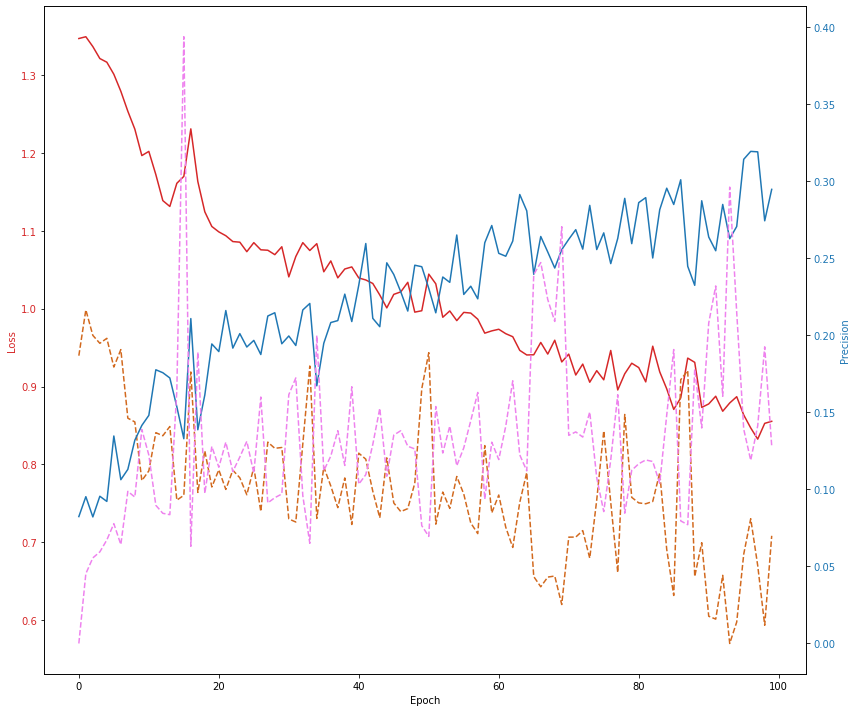

[I 2021-11-24 03:59:58,557] Trial 19 finished with value: 0.1328728983149037 and parameters: {'lr': 7.431037664728423e-05, 'weight_decay': 1.215243090073585e-06, 'num_layers': 5, 'hidden_channels': 420}. Best is trial 5 with value: 0.2582699813600665.


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  0.2582699813600665
  Params: 
    lr: 0.003443360276897034
    weight_decay: 3.437657176543441e-06
    num_layers: 4
    hidden_channels: 420


In [8]:
def objective_fp(trial):
    batch_size_test = 40
    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_ampc.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    # OPTUNA
    batch_size_train = 500 #trial.suggest_int('batch_size', 411, 511, step=100)
    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_ampc.csv' 
    model, criterion, optimizer, train_dataloader = get_all_optuna(trial, root, train_file_name, batch_size_train, shuffle=True)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 100
    test_precision_score_mean, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)

    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    #AX1
    fig, ax1 = plt.subplots(figsize=(12,10))
    #figure(figsize=(18, 16), dpi=300)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Loss
    t = range(EPOCHS)
    ax1.plot(t, train_total_loss, color='tab:red')
    ax1.plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # AX2
    # Presicion
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Precision', color='tab:blue')  
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax2.plot(t, train_precision_score, color='tab:blue')
    ax2.plot(t, test_precision_score, color='violet', linestyle='dashed')

    fig.tight_layout() 
    plt.show()

    # Training of the model.
    return test_precision_score_mean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
study.best_trials

[FrozenTrial(number=10, values=[1.0], datetime_start=datetime.datetime(2021, 11, 23, 17, 20, 8, 542162), datetime_complete=datetime.datetime(2021, 11, 23, 17, 36, 14, 801236), params={'batch_size': 511, 'lr': 0.0072660536360049715, 'weight_decay': 1.3232358675656123e-05, 'num_layers': 3, 'hidden_channels': 300, 'dropout': 0.7}, distributions={'batch_size': IntUniformDistribution(high=511, low=411, step=100), 'lr': LogUniformDistribution(high=0.01, low=1e-08), 'weight_decay': LogUniformDistribution(high=0.01, low=1e-08), 'num_layers': IntUniformDistribution(high=3, low=1, step=1), 'hidden_channels': IntUniformDistribution(high=400, low=100, step=100), 'dropout': DiscreteUniformDistribution(high=0.7, low=0.4, q=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=10, state=TrialState.COMPLETE, value=None)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



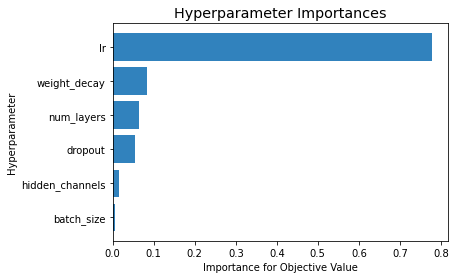

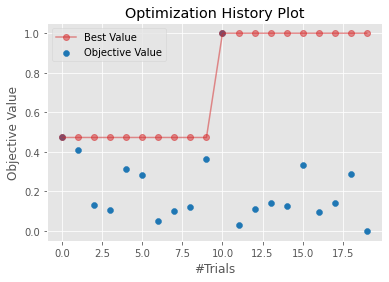

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);
plot_optimization_history(study);

---